In [1]:
import pandas as pd
from Main import settings, features, pf_set
import time
import pickle
from pandas.tseries.offsets import DateOffset
import Prepare_Data
import data_run_files
import return_prediction_functions
from return_prediction_functions import rff
import numpy as np
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import Ridge
import General_Functions
import pickle
import Estimate_Covariance_Matrix
import os
import prepare_portfolio_data
import portfolio_choice_functions
import scipy.linalg
import functools
import importlib
import numpy as np
from tqdm import tqdm
sqrtm_cpp = importlib.import_module("sqrtm_cpp")
ewma = importlib.import_module("ewma")
start_date = pd.to_datetime('1952-12-31')


Features list length: 154


In [2]:
folder_name = "new_data"

output_path = os.path.join(".", folder_name, "")
market_path = os.path.join(".", folder_name, "market_returns_test.csv")
pickle_file_path = os.path.join(".", folder_name, "model_1.pkl")
wealth_path = os.path.join(".", folder_name, "wealth.csv")
barra_file_path = os.path.join(".", folder_name, "barra_cov.pkl")
output_path_market_returns = os.path.join(folder_name, "market_returns_test.csv")

risk_free_path = os.path.join(".", folder_name, "risk_free_test.csv")
output_data_ret_csv = os.path.join(".", folder_name, "data_ret.csv")
output_data_ret_ld1_csv = os.path.join(".", folder_name, "data_ret_ld1.csv")
daily_path = os.path.join(".", folder_name, "daily.csv")
chars_path = os.path.join(".", folder_name, "chars_behandlet.parquet")
file_path_world_ret = os.path.join(".", folder_name, "world_ret_test.csv")
daily_file_path = os.path.join(".", folder_name, "usa_dsf_test.parquet")
output_path_usa = os.path.join(".", folder_name, "usa_test.parquet")
output_path_chars_behandlet =  os.path.join(".", folder_name, "chars_behandlet.parquet")
output_path_daily = os.path.join(".", folder_name, "daily.csv")
# Paths for Data-mappen forbliver uændrede
file_path_cluster_labels = os.path.join("Data", "Cluster Labels.csv")
file_path_factor_details = os.path.join("Data", "Factor Details.xlsx")

# Processering af risk_free (givet at start_date er defineret et andet sted)
risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date)

Filtrering udført. Antal rækker efter filtrering: 841
Fil gemt som ./data_test/risk_free_test.csv


In [3]:

wealth_end = pf_set["wealth"]
end = settings["split"]["test_end"]
market_test = Prepare_Data.load_and_filter_market_returns_test(market_path)

# Kører funktioner fra data_run_files
risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date)
h_list = [1]  # Horisonter
wealth = Prepare_Data.wealth_func(wealth_end, end, market_test, risk_free)

Filen er indlæst og filtreret succesfuldt.
Filtrering udført. Antal rækker efter filtrering: 841
Fil gemt som ./data_test/risk_free_test.csv


In [4]:
wealth_end = pf_set["wealth"]
end = settings["split"]["test_end"]
market_test = Prepare_Data.load_and_filter_market_returns_test(market_path)

# Kører funktioner fra data_run_files
risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date)
h_list = [1]  # Horisonter
wealth = Prepare_Data.wealth_func(wealth_end, end, market_test, risk_free)
wealth.to_csv(wealth_path, index=False)

Filen er indlæst og filtreret succesfuldt.
Filtrering udført. Antal rækker efter filtrering: 841
Fil gemt som ./data_test/risk_free_test.csv


In [5]:
df_test = pd.read_csv(file_path_world_ret)
kolonner = ["excntry", "id", "eom", "ret_exc"]
monthly = df_test[kolonner]
monthly = monthly[(monthly["excntry"] == "USA") & (monthly["id"] <= 99999)]
monthly["eom"] = pd.to_datetime(monthly["eom"])

# Beregn long horizon returns (antager, at funktionen long_horizon_ret er defineret)
data_ret = General_Functions.long_horizon_ret(data=monthly,
                                              h=settings['pf']['hps']['m1']['K'],
                                              impute="zero")

# Opret data_ret_ld1 med de relevante kolonner og beregn eom_ret
data_ret_ld1 = data_ret[['id', 'eom', 'ret_ld1']].copy()
data_ret_ld1['eom_ret'] = data_ret_ld1['eom'] + MonthEnd(1)

# Merge med risk_free og beregn total return tr_ld1
data_ret_ld1 = data_ret_ld1.merge(risk_free, on='eom', how='left')
data_ret_ld1['tr_ld1'] = data_ret_ld1['ret_ld1'] + data_ret_ld1['rf']

# Fjern kolonnen 'rf'
data_ret_ld1 = data_ret_ld1.drop(columns=['rf'])

# Opret et shiftet DataFrame for at få tr_ld0 (total return fra næste periode)
shifted = data_ret_ld1[['id', 'eom', 'tr_ld1']].copy()
shifted['eom'] = shifted['eom'] + MonthEnd(1)
shifted = shifted.rename(columns={'tr_ld1': 'tr_ld0'})

# Merge det shiftede DataFrame med data_ret_ld1 på 'id' og 'eom'
data_ret_ld1 = data_ret_ld1.merge(shifted[['id', 'eom', 'tr_ld0']], on=['id', 'eom'], how='left')

# Fjern den midlertidige variable 'monthly'
del monthly
data_ret.to_csv(output_data_ret_csv, index=False)
data_ret_ld1.to_csv(output_data_ret_ld1_csv, index=False)

All missing excludes 0.42% of the observations


In [6]:
chars = pd.read_parquet(output_path_usa)


# ---------------------------------------------------------
# 2. Definér de kolonner, der skal hentes (unik liste)
# Her antages, at 'features' er en liste med ekstra kolonnenavne
selected_cols = list(set(["id", "eom", "sic", "size_grp", "me", "rvol_252d", "dolvol_126d"] + features))
# Læs kun de nødvendige kolonner fra Parquet-filen
chars = pd.read_parquet(output_path_usa, columns=selected_cols)

chars = chars[chars['id'] <= 99999]
chars['eom'] = pd.to_datetime(chars['eom'])


chars['dolvol'] = chars['dolvol_126d']
# b) 'lambda' beregnes som 2/dolvol * settings['pi']
chars['lambda'] = 2 / chars['dolvol'] * settings['pi']
# c) 'rvol_m' beregnes som rvol_252d * sqrt(21)
chars['rvol_m'] = chars['rvol_252d'] * np.sqrt(21)

chars = pd.merge(chars, data_ret_ld1, on=['id', 'eom'], how='left')


temp = wealth.copy()
# Flyt eom til den sidste dag i næste måned:
temp['eom'] = temp['eom'] + pd.offsets.MonthEnd(1)
# Omdøb 'mu_ld1' til 'mu_ld0'
temp = temp.rename(columns={'mu_ld1': 'mu_ld0'})
# Merge wealth-data med chars på kolonnen eom
chars = pd.merge(chars, temp[['eom', 'mu_ld0']], on='eom', how='left')


# Date screen: Udregn andelen af rækker, hvor eom ligger uden for screens-intervallet
date_excludes = ((chars['eom'] < settings['screens']['start']) | (chars['eom'] > settings['screens']['end'])).mean() * 100
print(f"   Date screen excludes {date_excludes:.2f}% of the observations")

# Filtrer data, så kun rækker med eom inden for intervallet beholdes
chars = chars[(chars['eom'] >= settings['screens']['start']) & (chars['eom'] <= settings['screens']['end'])]

# Monitor screen impact
n_start = chars.shape[0]
me_start = chars['me'].sum(skipna=True)

# Require non-missing me
me_missing_pct = chars['me'].isna().mean() * 100
print(f"   Non-missing me excludes {me_missing_pct:.2f}% of the observations")
chars = chars[~chars['me'].isna()]

# Require non-missing return for t og t+1: (tr_ld1 og tr_ld0)
valid_return_excludes = ((chars['tr_ld1'].isna()) | (chars['tr_ld0'].isna())).mean() * 100
print(f"   Valid return req excludes {valid_return_excludes:.2f}% of the observations")
chars = chars[chars['tr_ld0'].notna() & chars['tr_ld1'].notna()]

dolvol_excludes = ((chars['dolvol'].isna()) | (chars['dolvol'] == 0)).mean() * 100
print(f"   Non-missing/non-zero dolvol excludes {dolvol_excludes:.2f}% of the observations")

# Filtrer rækker, hvor 'dolvol' ikke er missing og > 0
chars = chars[(~chars['dolvol'].isna()) & (chars['dolvol'] > 0)]

# --- Require valid SIC code ---
# Beregn andelen af observationer med en tom SIC (""), svarende til R's mean(chars$sic=="")
sic_excludes = (chars['sic'] == "").mean() * 100
print(f"   Valid SIC code excludes {sic_excludes:.2f}% of the observations")

# Filtrer rækker, hvor 'sic' ikke er missing
chars = chars[~chars['sic'].isna()]

# --- Feature screens ---
# For hver række beregnes antallet af ikke-missing feature-værdier (for de kolonner, der er defineret i 'features')
feat_available = chars[features].notna().sum(axis=1)

# Minimum antal features, som kræves: floor(antal features * settings['screens']['feat_pct'])
min_feat = int(np.floor(len(features) * settings['screens']['feat_pct']))

# Udregn procentdelen af observationer, hvor antallet af tilgængelige features er mindre end min_feat
feat_excludes = (feat_available < min_feat).mean() * 100
print(f"   At least {settings['screens']['feat_pct']*100:.0f}% of feature excludes {feat_excludes:.2f}% of the observations")

# Filtrer rækker, hvor antallet af tilgængelige features er >= min_feat
chars = chars[feat_available >= min_feat]

final_obs_pct = (len(chars) / n_start) * 100
final_me_pct = (chars['me'].sum() / me_start) * 100
print(
    f"   In total, the final dataset has {final_obs_pct:.2f}% of the observations and {final_me_pct:.2f}% of the market cap in the post {settings['screens']['start']} data")
run_sub = False
if run_sub:
    np.random.seed(settings['seed'])
    unique_ids = chars['id'].unique()
    sample_ids = np.random.choice(unique_ids, size=2500, replace=False)
    chars = chars[chars['id'].isin(sample_ids)]
if settings['feat_prank']:
    # Konverter feature-kolonner til float (dobbelt præcision)
    chars[features] = chars[features].astype(float)


    def ecdf_transform(s):
        return s.rank(method='average', pct=True)


    for i, f in enumerate(features):
        if (i + 1) % 10 == 0:
            print(f"Feature {i + 1} out of {len(features)}")

        zero = (chars[f] == 0)

        # Udfør ECDF-transformation per gruppe defineret af 'eom'
        chars[f] = chars.groupby('eom')[f].transform(lambda s: ecdf_transform(s))

        # Sæt de oprindelige 0-værdier tilbage til 0
        chars.loc[zero, f] = 0

if settings['feat_impute']:
    if settings['feat_prank']:
        # For hvert feature: hvis manglende, sæt til 0.5
        for f in features:
            chars[f] = chars[f].fillna(0.5)
    else:
        # For hvert feature: imputér manglende værdier med median inden for hver eom-gruppe
        for f in features:
            chars[f] = chars.groupby('eom')[f].transform(lambda s: s.fillna(s.median()))



# Konverter sic til numerisk (fejl konverteres til NaN)
chars['sic'] = pd.to_numeric(chars['sic'], errors='coerce')


cond_no_dur = (
    chars['sic'].between(100, 999) |
    chars['sic'].between(2000, 2399) |
    chars['sic'].between(2700, 2749) |
    chars['sic'].between(2770, 2799) |
    chars['sic'].between(3100, 3199) |
    chars['sic'].between(3940, 3989)
)

cond_durbl = (
    chars['sic'].between(2500, 2519) |
    chars['sic'].between(3630, 3659) |
    chars['sic'].isin([3710, 3711, 3714, 3716]) |
    chars['sic'].between(3750, 3751) |
    (chars['sic'] == 3792) |
    chars['sic'].between(3900, 3939) |
    chars['sic'].between(3990, 3999)
)

cond_manuf = (
    chars['sic'].between(2520, 2589) |
    chars['sic'].between(2600, 2699) |
    chars['sic'].between(2750, 2769) |
    chars['sic'].between(3000, 3099) |
    chars['sic'].between(3200, 3569) |
    chars['sic'].between(3580, 3629) |
    chars['sic'].between(3700, 3709) |
    chars['sic'].between(3712, 3713) |
    (chars['sic'] == 3715) |
    chars['sic'].between(3717, 3749) |
    chars['sic'].between(3752, 3791) |
    chars['sic'].between(3793, 3799) |
    chars['sic'].between(3830, 3839) |
    chars['sic'].between(3860, 3899)
)

cond_enrgy = (
    chars['sic'].between(1200, 1399) |
    chars['sic'].between(2900, 2999)
)

cond_chems = (
    chars['sic'].between(2800, 2829) |
    chars['sic'].between(2840, 2899)
)

cond_buseq = (
    chars['sic'].between(3570, 3579) |
    chars['sic'].between(3660, 3692) |
    chars['sic'].between(3694, 3699) |
    chars['sic'].between(3810, 3829) |
    chars['sic'].between(7370, 7379)
)

cond_telcm = chars['sic'].between(4800, 4899)
cond_utils = chars['sic'].between(4900, 4949)

cond_shops = (
    chars['sic'].between(5000, 5999) |
    chars['sic'].between(7200, 7299) |
    chars['sic'].between(7600, 7699)
)

cond_hlth = (
    chars['sic'].between(2830, 2839) |
    (chars['sic'] == 3693) |
    chars['sic'].between(3840, 3859) |
    chars['sic'].between(8000, 8099)
)

cond_money = chars['sic'].between(6000, 6999)

# Saml betingelser og tilhørende valg
conditions = [
    cond_no_dur,
    cond_durbl,
    cond_manuf,
    cond_enrgy,
    cond_chems,
    cond_buseq,
    cond_telcm,
    cond_utils,
    cond_shops,
    cond_hlth,
    cond_money
]

choices = [
    "NoDur",
    "Durbl",
    "Manuf",
    "Enrgy",
    "Chems",
    "BusEq",
    "Telcm",
    "Utils",
    "Shops",
    "Hlth",
    "Money"
]

# Opret kolonnen ff12 med værdien "Other", hvis ingen betingelser er opfyldte
chars['ff12'] = np.select(conditions, choices, default="Other")


# Først: sortér DataFrame (ingen indsættelser sker her)
chars.sort_values(['id', 'eom'], inplace=True)

# Beregn lb
lb = pf_set['lb_hor'] + 1

# Beregn eom_lag og month_diff som separate serier
eom_lag_series = chars.groupby('id')['eom'].shift(lb)

def calc_month_diff(row):
    # Hvis eom_lag er NaT, returner NaN
    if pd.isna(row['eom_lag']):
        return np.nan
    return (row['eom'].year - row['eom_lag'].year) * 12 + (row['eom'].month - row['eom_lag'].month)

# Lav en midlertidig DataFrame for beregninger (uden at ændre chars løbende)
temp_df = pd.concat([chars['eom'], eom_lag_series.rename('eom_lag')], axis=1)
temp_df['month_diff'] = temp_df.apply(lambda row: calc_month_diff(row), axis=1)

# Udregn exclusion rate (for de rækker hvor valid_data oprindeligt er True)
# Her antages alle observationer at være gyldige til at starte med
exclusion_rate = (((temp_df['month_diff'] != lb) | (temp_df['month_diff'].isna())).mean()) * 100
print(f"   Valid lookback observation screen excludes {exclusion_rate:.2f}% of the observations")

# Opdater valid_data: kun rækker med month_diff lig lb og ikke NaN er gyldige
valid_data_series = (temp_df['month_diff'] == lb) & (~temp_df['month_diff'].isna())

# Tilføj valid_data til chars ved at bruge pd.concat (samler alle nye kolonner på én gang)
new_cols = pd.DataFrame({
    'valid_data': valid_data_series,
    'eom_lag': temp_df['eom_lag'],
    'month_diff': temp_df['month_diff']
}, index=chars.index)

chars = pd.concat([chars, new_cols], axis=1)

# Opdater valid_data-kolonnen i chars
chars['valid_data'] = chars['valid_data']

# Fjern de midlertidige kolonner
chars.drop(columns=['eom_lag', 'month_diff'], inplace=True)

   Date screen excludes 18.44% of the observations
   Non-missing me excludes 0.00% of the observations
   Valid return req excludes 0.25% of the observations
   Non-missing/non-zero dolvol excludes 0.03% of the observations
   Valid SIC code excludes 0.03% of the observations
   At least 50% of feature excludes 0.00% of the observations
   In total, the final dataset has 99.73% of the observations and 99.37% of the market cap in the post 1982-12-31 00:00:00 data
Feature 10 out of 115
Feature 20 out of 115
Feature 30 out of 115
Feature 40 out of 115
Feature 50 out of 115
Feature 60 out of 115
Feature 70 out of 115
Feature 80 out of 115
Feature 90 out of 115
Feature 100 out of 115
Feature 110 out of 115


C:\Users\andre\AppData\Local\Temp\ipykernel_11384\3622406625.py:231: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


   Valid lookback observation screen excludes 3.60% of the observations


In [7]:
def investment_universe(add, delete):
    """
    Beregner en logisk vektor, der angiver om et aktiv (i en tidsserie)
    skal inkluderes i investeringsuniverset.

    Parametre:
      add (list eller 1D-array af bool): Tilføjningsflag pr. periode.
      delete (list eller 1D-array af bool): Sletningsflag pr. periode.

    Returnerer:
      included (list af bool): Resultat for hver periode.
    """
    n = len(add)
    included = [False] * n
    state = False
    # Start fra anden observation (python-indeks 1)
    for i in range(1, n):
        # Inkludér hvis aktivet ikke er inkluderet,
        # men får et tilføjningssignal nu (og ikke fik signal i forrige periode)
        if (not state) and add[i] and (not add[i - 1]):
            state = True
        # Fjern aktivet hvis det er inkluderet og får sletningssignal
        if state and delete[i]:
            state = False
        included[i] = state
    return included



def size_screen_fun(chars, type_screen):
    """
    Size-based screen function. Modifies DataFrame 'chars' in place.

    Parametre:
      chars (pd.DataFrame): DataFrame med mindst kolonnerne 'valid_data', 'me',
                            og evt. 'size_grp'.
      type_screen (str): Angiver, hvilken type screen der skal anvendes. Skal være
                         præcis én af:
                           - "all"
                           - "topN" (f.eks. "top1000")
                           - "bottomN" (f.eks. "bottom100")
                           - "size_grp_{gruppe}" (f.eks. "size_grp_small")
                           - En procent-baseret string indeholdende "perc", "low", "high" og "min"
                             f.eks. "perc_low20high80min50"

    Funktionen tjekker, at præcis én screen-type er anvendt. Hvis ikke, kastes en fejl.
    """
    count = 0
    # --- Screen: All ---
    if type_screen == "all":
        print("No size screen")
        chars.loc[chars['valid_data'] == True, 'valid_size'] = True
        count += 1

    # --- Screen: Top N ---
    if "top" in type_screen:
        # Ekstraher tallet fra strengen (fjerner alle ikke-cifrede tegn)
        top_n = int(re.sub(r"\D", "", type_screen))
        # For rækker hvor valid_data er True, beregn rangeringen af me (descending) inden for hver eom
        chars.loc[chars['valid_data'] == True, 'me_rank'] = chars.groupby('eom')['me'].rank(ascending=False,
                                                                                            method='first')
        # Sæt valid_size til True, hvis me_rank <= top_n og me_rank ikke er NA
        chars['valid_size'] = (chars['me_rank'] <= top_n) & (~chars['me_rank'].isna())
        # Fjern den midlertidige kolonne
        chars.drop(columns='me_rank', inplace=True)
        count += 1

    # --- Screen: Bottom N ---
    if "bottom" in type_screen:
        bot_n = int(re.sub(r"\D", "", type_screen))
        chars.loc[chars['valid_data'] == True, 'me_rank'] = chars.groupby('eom')['me'].rank(ascending=True,
                                                                                            method='first')
        chars['valid_size'] = (chars['me_rank'] <= bot_n) & (~chars['me_rank'].isna())
        chars.drop(columns='me_rank', inplace=True)
        count += 1

    # --- Screen: Size group ---
    if "size_grp_" in type_screen:
        size_grp_screen = type_screen.replace("size_grp_", "")
        chars['valid_size'] = (chars['size_grp'] == size_grp_screen) & (chars['valid_data'] == True)
        count += 1

    # --- Screen: Percentile-based ---
    if "perc" in type_screen:
        low_match = re.search(r"(?<=low)\d+", type_screen)
        high_match = re.search(r"(?<=high)\d+", type_screen)
        min_match = re.search(r"(?<=min)\d+", type_screen)
        if low_match and high_match and min_match:
            low_p = int(low_match.group())
            high_p = int(high_match.group())
            min_n = int(min_match.group())
        else:
            raise ValueError("Percentile screen format invalid.")
        print(f"Percentile-based screening: Range {low_p}% - {high_p}%, min_n: {min_n} stocks")
        # For rækker hvor valid_data er True: beregn ECDF for me inden for hver eom (brug rank i procent)
        chars.loc[chars['valid_data'] == True, 'me_perc'] = chars.groupby('eom')['me'].transform(
            lambda s: s.rank(method='average', pct=True))
        # Sæt valid_size til True, hvis me_perc ligger inden for (low_p/100, high_p/100]
        chars['valid_size'] = (chars['me_perc'] > (low_p / 100)) & (chars['me_perc'] <= (high_p / 100)) & (
            ~chars['me_perc'].isna())
        # Beregn gruppe-specifik statistik for hver eom
        group_stats = chars.groupby('eom').apply(lambda g: pd.Series({
            'n_tot': g['valid_data'].sum(),
            'n_size': g['valid_size'].sum(),
            'n_less': ((g['valid_data'] == True) & (g['me_perc'] <= (low_p / 100))).sum(),
            'n_more': ((g['valid_data'] == True) & (g['me_perc'] > (high_p / 100))).sum()
        }))
        # Merge disse stats tilbage til chars
        chars = chars.merge(group_stats, left_on='eom', right_index=True, how='left')
        # Beregn antallet af manglende aktier, der skal tilføjes
        chars['n_miss'] = np.maximum(min_n - chars['n_size'], 0)
        # Beregn hvor mange aktier der skal tilføjes fra neden og ovenfra
        chars['n_below'] = np.ceil(np.minimum(chars['n_miss'] / 2, chars['n_less']))
        chars['n_above'] = np.ceil(np.minimum(chars['n_miss'] / 2, chars['n_more']))
        # Juster, hvis summen af n_below og n_above er mindre end n_miss
        cond = (chars['n_below'] + chars['n_above'] < chars['n_miss']) & (chars['n_above'] > chars['n_below'])
        chars.loc[cond, 'n_above'] = chars.loc[cond, 'n_above'] + (
                    chars.loc[cond, 'n_miss'] - chars.loc[cond, 'n_above'] - chars.loc[cond, 'n_below'])
        cond = (chars['n_below'] + chars['n_above'] < chars['n_miss']) & (chars['n_above'] < chars['n_below'])
        chars.loc[cond, 'n_below'] = chars.loc[cond, 'n_below'] + (
                    chars.loc[cond, 'n_miss'] - chars.loc[cond, 'n_above'] - chars.loc[cond, 'n_below'])
        # Endelig: sæt valid_size, med en udvidet grænse baseret på de beregnede tilføjelser
        chars['valid_size'] = (chars['me_perc'] > (low_p / 100 - chars['n_below'] / chars['n_tot'])) & \
                              (chars['me_perc'] <= (high_p / 100 + chars['n_above'] / chars['n_tot'])) & \
                              (~chars['me_perc'].isna())
        # Fjern de midlertidige kolonner
        for col in ['me_perc', 'n_tot', 'n_size', 'n_less', 'n_more', 'n_miss', 'n_below', 'n_above']:
            if col in chars.columns:
                chars.drop(columns=col, inplace=True)
        count += 1

    if count != 1:
        raise ValueError("Invalid size screen applied!!!!")

    return chars
def addition_deletion_fun(chars, addition_n, deletion_n, pf_set):
    """
    Anvender addition/deletion-reglen på DataFrame 'chars'.

    Parametre:
      chars (pd.DataFrame): Datasættet med aktieobservationer.
      addition_n (int): Vindueslængde for addition (rullende sum).
      deletion_n (int): Vindueslængde for deletion (rullende sum).
      pf_set (dict): Indstillinger; herunder forventes pf_set['lb_hor'] at være defineret.

    Funktionen:
      - Opretter en midlertidig kolonne 'valid_temp' (valid_data AND valid_size)
      - Sorterer data efter id og eom.
      - Beregner rullende summer for valid_temp over vinduerne addition_n og deletion_n.
      - Definerer flagget 'add' (når addition_count == addition_n) og 'delete' (når deletion_count == 0).
      - For hver aktie (id) med mere end én observation, anvendes investment_universe til at udlede en kolonne 'valid'.
      - For aktier med kun én observation sættes valid til False.
      - Hvis valid_data er False, sættes valid til False.
      - Beregner turnover (ændring) både for den rå validitet (valid_temp) og den justerede validitet (valid).
      - Udregner og printer gennemsnitlig turnover pr. eom.
      - Fjerner de midlertidige kolonner.
    """
    # 1. Opret valid_temp
    chars['valid_temp'] = (chars['valid_data'] == True) & (chars['valid_size'] == True)

    # 2. Sortér efter id og eom
    chars.sort_values(['id', 'eom'], inplace=True)

    # 3. Beregn rullende summer for valid_temp inden for hver id
    chars['valid_int'] = chars['valid_temp'].astype(int)
    chars['addition_count'] = chars.groupby('id')['valid_int'] \
        .transform(lambda s: s.rolling(window=addition_n, min_periods=addition_n).sum())
    chars['deletion_count'] = chars.groupby('id')['valid_int'] \
        .transform(lambda s: s.rolling(window=deletion_n, min_periods=deletion_n).sum())

    # 4. Definer flag for addition og deletion
    chars['add'] = (chars['addition_count'] == addition_n)
    chars['add'] = chars['add'].fillna(False)
    chars['delete'] = (chars['deletion_count'] == 0)
    chars['delete'] = chars['delete'].fillna(False)

    # 5. Beregn antallet af observationer per id
    chars['n'] = chars.groupby('id')['id'].transform('count')

    # 6. Anvend investment_universe for at udlede 'valid'
    def apply_investment_universe(df):
        add_list = df['add'].tolist()
        delete_list = df['delete'].tolist()
        valid_list = investment_universe(add_list, delete_list)
        return pd.Series(valid_list, index=df.index)

    chars.loc[chars['n'] > 1, 'valid'] = chars.groupby('id').apply(
        lambda g: apply_investment_universe(g) if len(g) > 1 else False
    ).reset_index(level=0, drop=True)

    chars.loc[chars['n'] == 1, 'valid'] = False
    chars.loc[chars['valid_data'] == False, 'valid'] = False

    # 7. Beregn Turnover
    chars['chg_raw'] = chars.groupby('id')['valid_temp'].transform(lambda s: s != s.shift(1))
    chars['chg_adj'] = chars.groupby('id')['valid'].transform(lambda s: s != s.shift(1))

    chars['valid_temp_int'] = chars['valid_temp'].astype(int)
    chars['valid_int_new'] = chars['valid'].astype(int)
    chars['chg_raw_int'] = chars['chg_raw'].astype(int)
    chars['chg_adj_int'] = chars['chg_adj'].astype(int)

    # Aggreger pr. eom
    turnover = chars.groupby('eom').agg(
        raw_n=pd.NamedAgg(column='valid_temp_int', aggfunc='sum'),
        adj_n=pd.NamedAgg(column='valid_int_new', aggfunc='sum'),
        raw=pd.NamedAgg(column='chg_raw_int', aggfunc='sum'),
        total_valid_temp=pd.NamedAgg(column='valid_temp_int', aggfunc='sum'),
        total_valid=pd.NamedAgg(column='valid_int_new', aggfunc='sum'),
        adj_sum=pd.NamedAgg(column='chg_adj_int', aggfunc='sum')
    ).reset_index()

    turnover['raw'] = turnover.apply(
        lambda row: row['raw'] / row['total_valid_temp'] if row['total_valid_temp'] > 0 else np.nan, axis=1)
    turnover['adj'] = turnover.apply(
        lambda row: row['adj_sum'] / row['total_valid'] if row['total_valid'] > 0 else np.nan, axis=1)

    valid_turnover = turnover[(~turnover['raw'].isna()) & (~turnover['adj'].isna()) & (turnover['adj'] != 0)]

    # Her beregner vi gennemsnittet af turnover over alle eom
    mean_raw = valid_turnover['raw'].mean()
    mean_adj = valid_turnover['adj'].mean()

    print(f"Turnover wo addition/deletion rule: {mean_raw * 100:.2f}%")
    print(f"Turnover w  addition/deletion rule: {mean_adj * 100:.2f}%")

    # 8. Fjern midlertidige kolonner
    cols_to_drop = ['n', 'addition_count', 'deletion_count', 'add', 'delete',
                    'valid_temp', 'valid_data', 'valid_size',
                    'chg_raw', 'chg_adj', 'valid_temp_int', 'valid_int_new',
                    'chg_raw_int', 'chg_adj_int']
    chars.drop(columns=cols_to_drop, inplace=True)

    return chars

In [8]:
type_screen = "all"
chars = size_screen_fun(chars, type_screen)
chars = addition_deletion_fun(chars, addition_n=settings['addition_n'], deletion_n=settings['deletion_n'], pf_set=settings)


# Plot investable universe - udkommenteret
valid_counts = chars.loc[chars['valid'] == True].groupby('eom').size().reset_index(name='N')
#plt.figure(figsize=(10,6))
#sns.scatterplot(data=valid_counts, x='eom', y='N')
#plt.ylabel("Valid stocks")
#plt.axhline(y=0, color='gray', linestyle='--')
#plt.title("Investable Universe")
#plt.show()

valid_pct = (chars['valid'].mean() * 100)
market_cap_valid = (chars.loc[chars['valid'] == True, 'me'].sum() / chars['me'].sum()) * 100
print(f"   The valid_data subset has {valid_pct:.2f}% of the observations and {market_cap_valid:.2f}% of the market cap")
chars.drop(columns="valid_int", inplace=True)


chars.to_parquet(output_path_chars_behandlet, index=False)

No size screen


C:\Users\andre\AppData\Local\Temp\ipykernel_11384\1289734657.py:187: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Turnover wo addition/deletion rule: 0.91%
Turnover w  addition/deletion rule: 1.66%
   The valid_data subset has 93.39% of the observations and 99.38% of the market cap


In [9]:
daily = pd.read_parquet(daily_file_path, engine='pyarrow')
daily = daily[(daily['ret_exc'].notna()) &
              (daily['id'] <= 99999) &
              (daily['id'].isin(chars.loc[chars['valid'] == True, 'id'].unique()))]

# Tilføj en ny kolonne 'eom' med månedens sidste dag
daily['eom'] = daily['date'] + MonthEnd(0)
daily.to_csv(output_path_daily, index=False)

In [10]:
#wealth = pd.read_csv(wealth_path)
wealth['eom'] = pd.to_datetime(wealth['eom'])
data_ret = pd.read_csv(output_data_ret_csv)
data_ret_ld1 = pd.read_csv(output_data_ret_ld1_csv)
data_ret['eom'] = pd.to_datetime(data_ret['eom'])
data_ret_ld1['eom'] = pd.to_datetime(data_ret_ld1['eom'])
data_ret_ld1['eom_ret'] = pd.to_datetime(data_ret_ld1['eom_ret'])
daily = pd.read_csv(daily_path, parse_dates=["date", "eom"])
chars = pd.read_parquet(chars_path)

In [11]:
with open(barra_file_path, "rb") as file:
    barra_cov = pickle.load(file)

In [12]:
barra_cov['2012-12-31']['fct_cov']

BusEq     Chems     Durbl     Enrgy      Hlth  \
BusEq                0.003178  0.002853  0.003023  0.003058  0.002654   
Chems                0.002853  0.003181  0.002955  0.003144  0.002593   
Durbl                0.003023  0.002955  0.003987  0.003077  0.002621   
Enrgy                0.003058  0.003144  0.003077  0.004507  0.002764   
Hlth                 0.002654  0.002593  0.002621  0.002764  0.002779   
Manuf                0.003007  0.002972  0.003107  0.003311  0.002640   
Money                0.002862  0.002719  0.002956  0.002838  0.002629   
NoDur                0.002511  0.002512  0.002576  0.002606  0.002311   
Other                0.002823  0.002770  0.002975  0.002951  0.002509   
Shops                0.002525  0.002500  0.002635  0.002546  0.002310   
Telcm                0.002491  0.002449  0.002540  0.002640  0.002258   
Utils                0.002354  0.002287  0.002384  0.002536  0.002102   
accruals            -0.000051 -0.000051 -0.000064 -0.000082 -0.000043   
debt_issuance       -0.000039 -0.000045 -0.000055 -0.000052 -0.000027   
investment           0.000026  0.000014  0.000039  0.000004  0.000023   
low_leverage        -0.000036 -0.000021 -0.000057 -0.000027 -0.000049   
low_risk            -0.000670 -0.000645 -0.000688 -0.000667 -0.000591   
momentum            -0.000117 -0.000092 -0.000099 -0.000099 -0.000105   
profit_growth        0.000025  0.000033  0.000015  0.000054  0.000022   
profitability        0.000054  0.000056  0.000051  0.000071  0.000043   
quality             -0.000102 -0.000160 -0.000086 -0.000204 -0.000135   
seasonality         -0.000039 -0.000041 -0.000047 -0.000009 -0.000029   
short_term_reversal  0.000080  0.000070  0.000075  0.000080  0.000069   
size                 0.000015  0.000021  0.000020  0.000024  0.000018   
value                0.000037  0.000038  0.000014  0.000018  0.000036   

                        Manuf     Money     NoDur     Other     Shops  ...  \
BusEq                0.003007  0.002862  0.002511  0.002823  0.002525  ...   
Chems                0.002972  0.002719  0.002512  0.002770  0.002500  ...   
Durbl                0.003107  0.002956  0.002576  0.002975  0.002635  ...   
Enrgy                0.003311  0.002838  0.002606  0.002951  0.002546  ...   
Hlth                 0.002640  0.002629  0.002311  0.002509  0.002310  ...   
Manuf                0.003268  0.002833  0.002562  0.002897  0.002562  ...   
Money                0.002833  0.003371  0.002465  0.002781  0.002513  ...   
NoDur                0.002562  0.002465  0.002437  0.002443  0.002270  ...   
Other                0.002897  0.002781  0.002443  0.002896  0.002468  ...   
Shops                0.002562  0.002513  0.002270  0.002468  0.002480  ...   
Telcm                0.002534  0.002441  0.002189  0.002405  0.002181  ...   
Utils                0.002400  0.002351  0.002077  0.002279  0.002061  ...   
accruals            -0.000055 -0.000054 -0.000027 -0.000055 -0.000038  ...   
debt_issuance       -0.000041 -0.000061 -0.000032 -0.000047 -0.000042  ...   
investment           0.000020  0.000072  0.000032  0.000029  0.000046  ...   
low_leverage        -0.000032 -0.000081 -0.000026 -0.000052 -0.000036  ...   
low_risk            -0.000662 -0.000703 -0.000577 -0.000646 -0.000583  ...   
momentum            -0.000091 -0.000152 -0.000092 -0.000099 -0.000099  ...   
profit_growth        0.000034  0.000011  0.000021  0.000023  0.000016  ...   
profitability        0.000053  0.000033  0.000053  0.000041  0.000056  ...   
quality             -0.000121 -0.000064 -0.000124 -0.000081 -0.000113  ...   
seasonality         -0.000039 -0.000048 -0.000051 -0.000046 -0.000049  ...   
short_term_reversal  0.000073  0.000084  0.000066  0.000068  0.000066  ...   
size                 0.000025 -0.000016  0.000017  0.000019  0.000020  ...   
value                0.000031  0.000026  0.000031  0.000037  0.000022  ...   

                     low_leverage      low_risk      momentum  profit_growth  \
BusEq           

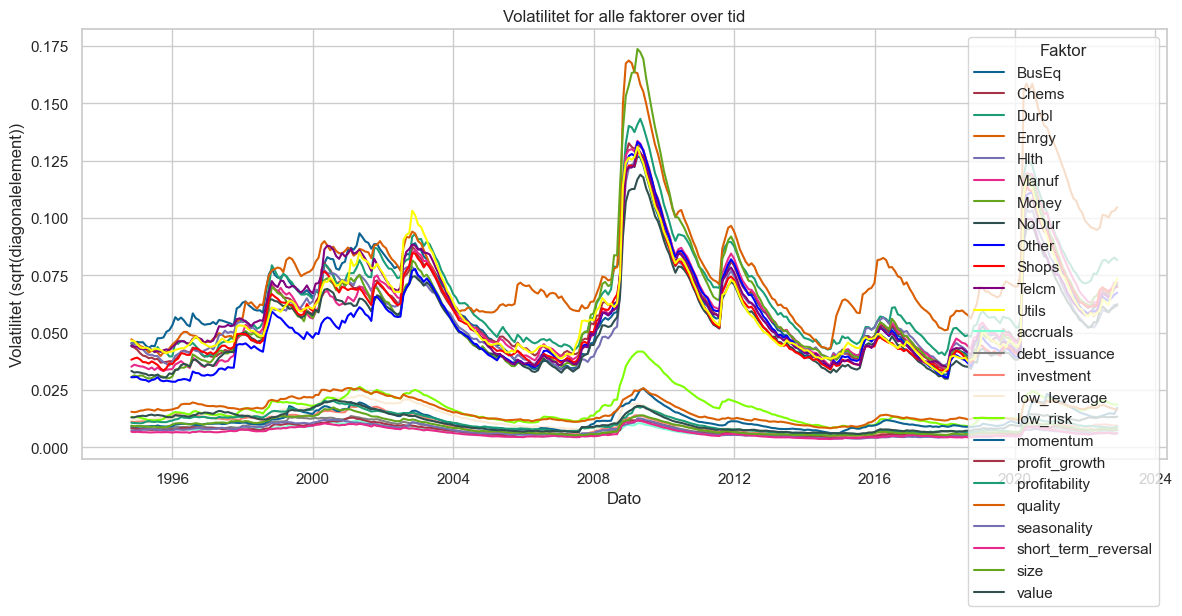

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Forudsætning: barra_cov er en dictionary, hvor nøglerne er datoer,
# og hver værdi er en dictionary med en key 'fct_cov', der er en pandas DataFrame.
# Eksempel: barra_cov['2012-12-31']['fct_cov']

# Sorter datoerne
dates = sorted(barra_cov.keys())

# Hent faktornavne fra fct_cov for den første dato
first_date = dates[0]
factor_names = barra_cov[first_date]['fct_cov'].columns.tolist()

# Saml data: for hver dato og for hver faktor udregnes volatiliteten (sqrt af diagonalelementet)
records = []
for date in dates:
    df = barra_cov[date]['fct_cov']
    for factor in factor_names:
        vol = np.sqrt(df.loc[factor, factor])
        records.append({'date': pd.to_datetime(date), 'factor': factor, 'vol': vol})

# Konverter listen til en DataFrame
vol_data = pd.DataFrame(records)

# Plot: lav en linje for hver faktor over tid
plt.figure(figsize=(12, 6))
for factor in factor_names:
    subset = vol_data[vol_data['factor'] == factor]
    plt.plot(subset['date'], subset['vol'], label=factor)

plt.title("Volatilitet for alle faktorer over tid")
plt.xlabel("Dato")
plt.ylabel("Volatilitet (sqrt(diagonalelement))")
plt.legend(title="Faktor")
plt.tight_layout()
plt.show()


# Ny generering af chars

In [49]:
from Prepare_Data import process_cluster_labels
cluster_labels_path = "Data/Cluster Labels.csv"
factor_details_path = "Data/Factor Details.xlsx"

## Del 1 - Denne er korrekt

In [50]:
 # Indlæs cluster labels separat (bruger samme metode som i den anden version)


# Filtrer gyldige karakteristika
valid_chars = chars[chars["valid"] == True]
cluster_data_m = valid_chars[["id", "eom", "size_grp", "ff12"] + features].copy()
#print(cluster_data_m)
#print(cluster_data_m.shape)
cluster_labels = process_cluster_labels(cluster_labels_path, factor_details_path)
#print(cluster_labels)
#print(cluster_labels.shape)
clusters = cluster_labels["cluster"].unique()
cluster_ranks = {}

for cl in clusters:
    chars_sub = cluster_labels[(cluster_labels["cluster"] == cl) & (cluster_labels["characteristic"].isin(features))]

    # Undgå potentielle fejl ved at sikre, at kun eksisterende kolonner vælges
    valid_features = [c for c in chars_sub["characteristic"].values if c in cluster_data_m.columns]
    data_sub = cluster_data_m[valid_features].copy()

    for c in valid_features:
        dir_value = chars_sub.loc[chars_sub["characteristic"] == c, "direction"].values[0]
        if dir_value == -1:
            data_sub[c] = 1 - data_sub[c]

    cluster_ranks[cl] = data_sub.mean(axis=1)

# Konverter cluster ranks til DataFrame
cluster_ranks_df = pd.DataFrame(cluster_ranks)
# Kombiner med de oprindelige data
cluster_data_m = cluster_data_m[["id", "eom", "size_grp", "ff12"]].copy()
cluster_data_m["eom_ret"] = cluster_data_m["eom"] + pd.DateOffset(months=1)
cluster_data_m["eom_ret"] = cluster_data_m["eom_ret"] + MonthEnd(0)
# Merge cluster rankings
cluster_data_m = pd.concat([cluster_data_m, cluster_ranks_df], axis=1)

In [51]:
print(cluster_data_m.shape)

(116889, 18)


In [52]:
# Tilføj industry/market dummies
if settings["cov_set"]["industries"]:
    industries = sorted(cluster_data_m["ff12"].unique())
    for ind in industries:
        cluster_data_m[str(ind)] = (cluster_data_m["ff12"] == ind).astype(int)
    ind_factors = industries  # vi bruger ikke denne her?
else:
    cluster_data_m["mkt"] = 1
    ind_factors = ["mkt"]  # vi bruger ikke denne her?
print(cluster_data_m.shape)

(116889, 30)


In [53]:
# Standardiser faktorer per eom (Bruger samme metode som den anden version)
cluster_data_m[clusters] = cluster_data_m.groupby("eom")[clusters].transform(lambda x: (x - x.mean()) / x.std())

In [54]:
print(cluster_data_m.shape)

(116889, 30)


In [55]:
# Indlæs daglige returdata
min_eom = cluster_data_m["eom"].min()
daily_filtered = daily[daily["date"] >= min_eom][["id", "date", "ret_exc", "eom"]].copy()
daily_filtered.rename(columns={"eom": "eom_ret"}, inplace=True)

# Flet daglige data med cluster_data_m
cluster_data_d = cluster_data_m.merge(daily_filtered, on=["id", "eom_ret"], how="inner")
print(cluster_data_d)


            id        eom size_grp   ff12    eom_ret  low_leverage  \
0        10104 1988-11-30    large  BusEq 1988-12-31      2.095347   
1        10104 1988-11-30    large  BusEq 1988-12-31      2.095347   
2        10104 1988-11-30    large  BusEq 1988-12-31      2.095347   
3        10104 1988-11-30    large  BusEq 1988-12-31      2.095347   
4        10104 1988-11-30    large  BusEq 1988-12-31      2.095347   
...        ...        ...      ...    ...        ...           ...   
2453954  92655 2022-11-30     mega  Money 2022-12-31      0.467888   
2453955  92655 2022-11-30     mega  Money 2022-12-31      0.467888   
2453956  92655 2022-11-30     mega  Money 2022-12-31      0.467888   
2453957  92655 2022-11-30     mega  Money 2022-12-31      0.467888   
2453958  92655 2022-11-30     mega  Money 2022-12-31      0.467888   

         investment      size     value   quality  ...  Hlth  Manuf  Money  \
0         -1.662852  0.894203 -2.198870  1.869123  ...     0      0      0   
1  

In [56]:
print(cluster_data_d.shape)
# Fjern manglende værdier
cluster_data_d.dropna(inplace=True)
print(cluster_data_d.shape)

(2453959, 32)
(2453959, 32)


In [57]:
ind_factors

['BusEq',
 'Chems',
 'Durbl',
 'Enrgy',
 'Hlth',
 'Manuf',
 'Money',
 'NoDur',
 'Other',
 'Shops',
 'Telcm',
 'Utils']

## Del 2 - Denne er korrekt

In [58]:
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# Kombiner de forklarende variable
all_factors = list(ind_factors) + list(clusters)
formula = "ret_exc ~ -1 + " + " + ".join(all_factors)

results = []
# Gruppér data efter 'date'
for date, group in cluster_data_d.groupby('date'):
    # Kør regressionen uden intercept (-1)
    model = smf.ols(formula=formula, data=group).fit()
    # Udtræk residualer
    residuals = model.resid
    # Opret en "tidy" oversigt over regressionsresultaterne vha. summary2
    tidy_df = model.summary2().tables[1].reset_index().rename(columns={'index': 'term'})

    results.append({
        'date': date,
        'data': group,
        'fit': model,
        'res': residuals,
        'tidied': tidy_df
    })

fct_ret_est = pd.DataFrame(results)

# Del 3 - Denne er korrekt

In [59]:
tidied_list = []
# Gå igennem hver række i fct_ret_est
for _, row in fct_ret_est.iterrows():
    # Kopiér den nestede DataFrame
    tidy_df = row['tidied'].copy()
    # Hvis kolonnen hedder "Coef.", omdøb den til "estimate"
    if 'Coef.' in tidy_df.columns:
        tidy_df = tidy_df.rename(columns={'Coef.': 'estimate'})
    # Tilføj datoen fra den overordnede række
    tidy_df['date'] = row['date']
    # Vælg kun de ønskede kolonner
    tidied_list.append(tidy_df[['date', 'term', 'estimate']])

# Sammensæt alle de unnestede DataFrames
combined = pd.concat(tidied_list, ignore_index=True)

# Pivotér dataene: 'date' bliver indeks, 'term' bliver kolonnenavne, og cellerne udfyldes med 'estimate'
fct_ret = combined.pivot(index='date', columns='term', values='estimate').reset_index()

# Sortér efter 'date'
fct_ret = fct_ret.sort_values('date').reset_index(drop=True)

## Del 4 - Denne er korrekt

In [60]:
w_cor = (0.5 ** (1 / settings['cov_set']['hl_cor'])) ** np.arange(settings['cov_set']['obs'], 0, -1)
w_var = (0.5 ** (1 / settings['cov_set']['hl_var'])) ** np.arange(settings['cov_set']['obs'], 0, -1)
fct_dates = np.sort(fct_ret["date"].unique())
min_calc_date = fct_dates[settings["cov_set"]["obs"] - 1] - pd.DateOffset(months=1)
calc_dates = np.sort(cluster_data_m.loc[cluster_data_m["eom"] >= min_calc_date, "eom"].unique())

## Del 5 - Denne er korrekt (begge af dem virker, testede med den første)

In [61]:
def weighted_cov(
        df: pd.DataFrame,
        weights: np.ndarray,
        correlation: bool = False,
        center: bool = True,
        unbiased: bool = True
) -> np.ndarray:
    """
    Tilsvarende en 'cov.wt' i R, der kan returnere enten en kovarians- eller korrelationsmatrix.

    Parametre:
    - df: DataFrame med observationsrækker og faktorkolonner (ingen 'date'-kolonne).
    - weights: Numpy-array med vægte (samme længde som df).
    - correlation: Hvis True, returneres en korrelationsmatrix. Ellers en kovariansmatrix.
    - center: Hvis True, fratrækkes det vægtede gennemsnit af hver kolonne.
    - unbiased: Hvis True, bruger vi (sum(weights) - 1) i nævneren, ellers sum(weights).

    Returnerer:
    - Et numpy 2D-array med kovarians- eller korrelationsmatricen.
    """
    if len(df) != len(weights):
        raise ValueError("Antal rækker i df skal matche længden af weights.")

    # Summer af vægte
    w_sum = weights.sum()

    # (Evt.) fratræk vægtet gennemsnit
    if center:
        w_mean = np.average(df, axis=0, weights=weights)
    else:
        w_mean = np.zeros(df.shape[1])

    # Center data
    X_centered = df - w_mean

    expanded_weights = weights[:, np.newaxis]
    numerator = (X_centered.values * expanded_weights).T @ X_centered.values

    if unbiased:
        denominator = w_sum - 1
    else:
        denominator = w_sum

    # Kovariansmatrix
    cov_mat = numerator / denominator

    # Hvis vi vil have korrelationsmatrix, normaliserer vi med standardafvigelserne
    if correlation:
        std_diag = np.sqrt(np.diag(cov_mat))
        # Undgå division med 0, fx hvis en faktor har 0-variance
        with np.errstate(divide='ignore', invalid='ignore'):
            corr_mat = cov_mat / np.outer(std_diag, std_diag)
            np.fill_diagonal(corr_mat, 1.0)  # sæt diagonalen til 1
        return corr_mat
    else:
        return cov_mat

In [62]:
factor_cov_est = {}

for d in calc_dates:
    # 1) Find det rullende vindue for dato d
    #    (forudsat at fct_dates er en liste/array af datotidspunkter)
    valid_fct_dates = [fd for fd in fct_dates if fd <= d]
    # Tag de seneste 'obs' antal datoer
    tail_fct_dates = valid_fct_dates[-settings["cov_set"]["obs"]:]

    # Hvis der ikke er nok data i starten, kan det give fejl
    if not tail_fct_dates:
        print(f"Advarsel: Ingen tilgængelige datoer for {d}")
        continue

    first_obs = min(tail_fct_dates)

    # 2) Filtrer data til vinduet [first_obs, d]
    #    fct_ret antages at være en DataFrame med en 'date'-kolonne
    cov_data = fct_ret[(fct_ret["date"] >= first_obs) & (fct_ret["date"] <= d)]
    t = len(cov_data)

    # Tjek om der er nok observationer
    if t < settings["cov_set"]["obs"] - 30:
        print("WARNING: INSUFFICIENT NUMBER OF OBSERVATIONS!!")

    # 3) Beregn vægtet korrelation og varians
    #    - w_cor_t og w_var_t er de sidste t vægte (ligesom tail(w_cor, t))
    w_cor_t = w_cor[-t:]
    w_var_t = w_var[-t:]

    # Kolonnerne med faktorer (antager at alt undtagen 'date' er faktorer)
    factor_cols = [col for col in cov_data.columns if col != "date"]

    cor_est = weighted_cov(
        df=cov_data[factor_cols],
        weights=w_cor_t,
        correlation=True,
        center=True,
        unbiased=True
    )

    var_est = weighted_cov(
        df=cov_data[factor_cols],
        weights=w_var_t,
        correlation=False,
        center=True,
        unbiased=True
    )

    # 4) Kombinér til en endelig kovariansmatrix
    sd_diag = np.diag(np.sqrt(np.diag(var_est)))
    cov_est = sd_diag @ cor_est @ sd_diag

    # Læg i en DataFrame for navngivne rækker og kolonner
    cov_est_df = pd.DataFrame(cov_est, index=factor_cols, columns=factor_cols)

    # 5) Gem resultatet i et dictionary, keyed af dato d
    factor_cov_est[d] = cov_est_df

Denne nedenunder virker :D, lige sat i kommentar, men den anden virker også

In [61]:
"""
import pandas as pd
import numpy as np
from tqdm import tqdm

# Antag at calc_dates, fct_dates, fct_ret, settings, w_cor og w_var er defineret

# Eksempel på, hvordan calc_dates og fct_dates kunne se ud:
# calc_dates = pd.date_range(start="2020-01-31", end="2020-12-31", freq="M").to_pydatetime().tolist()
# fct_dates = sorted(fct_ret["date"].unique())

factor_cov_est = {}

for d in tqdm(calc_dates, desc="Processing dates"):
    # Sørg for, at d er en datetime
    d_date = pd.to_datetime(d)
    
    # Find de fct_dates, der er <= d_date
    valid_fct_dates = [fd for fd in fct_dates if pd.to_datetime(fd) <= d_date]
    
    # Tag de seneste 'obs' observationer
    if len(valid_fct_dates) >= settings["cov_set"]["obs"]:
        tail_dates = valid_fct_dates[-settings["cov_set"]["obs"]:]
    else:
        tail_dates = valid_fct_dates  # Hvis der ikke er nok, brug dem alle
        
    # first_obs er den tidligste af de sidste obs observationer
    first_obs = min(tail_dates)
    
    # Filtrer fct_ret: behold rækker hvor date er mellem first_obs og d_date
    cov_data = fct_ret[(fct_ret["date"] >= pd.to_datetime(first_obs)) & 
                       (fct_ret["date"] <= d_date)].copy()
    t = len(cov_data)
    
    if t < settings["cov_set"]["obs"] - 30:
        print(f"WARNING: INSUFFICIENT NUMBER OF OBSERVATIONS!! for date {d_date.date()}")
    
    # Vælg kun numeriske kolonner (ekskl. 'date') og erstat NA med 0
    cov_numeric = cov_data.drop(columns=["date"]).copy()
    cov_numeric = cov_numeric.fillna(0)
    
    # Udtræk de sidste t vægte fra w_cor og w_var
    weights_cor = w_cor[-t:]
    weights_var = w_var[-t:]
    
    # Beregn vægtet korrelationsmatrix og variansmatrix
    cor_est = weighted_cov(
        df=cov_numeric,
        weights=weights_cor,
        correlation=True,
        center=True,
        unbiased=True
    )
    
    var_est = weighted_cov(
        df=cov_numeric,
        weights=weights_var,
        correlation=False,
        center=True,
        unbiased=True
    )
    
    # Udregn standardafvigelses-diagonalen fra var_est
    sd_diag = np.diag(np.sqrt(np.diag(var_est)))
    
    # Kombiner for at få den endelige kovariansmatrix
    final_cov = sd_diag @ cor_est @ sd_diag
    
    # Konverter til en DataFrame med de korrekte rækker og kolonnenavne
    final_cov_df = pd.DataFrame(final_cov, index=cov_numeric.columns, columns=cov_numeric.columns)
    
    # Gem resultatet med datoen som nøgle (fx som string)
    factor_cov_est[d_date.strftime("%Y-%m-%d")] = final_cov_df

# factor_cov_est er nu et dictionary med nøgler som datoer og værdier som kovariansmatricer.
"""

Processing dates: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338/338 [02:32<00:00,  2.22it/s]


## Del 6 - Denne er korrekt

In [81]:
#spec_risk = unnest_spec_risk(fct_ret_est)
#spec_risk_res_vol = calculate_ewma(spec_risk, settings)

In [63]:
# Arbejd på en kopi af fct_ret_est
df = fct_ret_est.copy()

# 1. Udtræk 'id'-kolonnen fra den nestede 'data'-kolonne
df['id'] = df['data'].apply(lambda nested_df: nested_df['id'].tolist())

# 2. Vælg kun de relevante kolonner
spec_risk = df[['id', 'date', 'res']].copy()

# 3. Kombiner de to list-kolonner (id og res) pr. række til en liste af tuples
spec_risk['id_res'] = spec_risk.apply(lambda row: list(zip(row['id'], row['res'])), axis=1)

# 4. Eksploder (unnest) den nye kolonne 'id_res'
spec_risk = spec_risk.explode('id_res')

# 5. Split tuple-kolonnen 'id_res' op i to separate kolonner: 'id' og 'res'
spec_risk[['id', 'res']] = pd.DataFrame(spec_risk['id_res'].tolist(), index=spec_risk.index)

# 6. Fjern hjælpekolonnen 'id_res'
spec_risk = spec_risk.drop(columns=['id_res'])

# 7. Sorter resultaterne efter 'id' og 'date'
spec_risk = spec_risk.sort_values(['id', 'date']).reset_index(drop=True)

In [64]:
print(spec_risk)
print(spec_risk.shape)

            id       date       res
0        10104 1988-12-01 -0.002419
1        10104 1988-12-02  0.008207
2        10104 1988-12-05  0.044145
3        10104 1988-12-06 -0.019126
4        10104 1988-12-07  0.015409
...        ...        ...       ...
2453954  92655 2022-12-23  0.004365
2453955  92655 2022-12-27  0.000763
2453956  92655 2022-12-28 -0.000008
2453957  92655 2022-12-29 -0.000326
2453958  92655 2022-12-30  0.008611

[2453959 rows x 3 columns]
(2453959, 3)


## Del 7 - Denne er korrekt (dog er der enkelte numeriske forskel på 5-6 decimaler efter brug af EMWA.cpp i spec_risk_m i res_vol kolonnen, men burde ikke have nogen betydning)

In [65]:
def calculate_ewma(spec_risk, settings):
    lambda_val = 0.5 ** (1.0 / settings['cov_set']['hl_stock_var'])
    start_val = settings['cov_set']['initial_var_obs']

    def apply_ewma(group):
        group = group.copy()  # Sikrer, at vi ikke ændrer originalen
        group['res_vol'] = ewma.ewma_c(group['res'].values, lambda_val, start_val)
        return group

    # Anvend EWMA per gruppe og returner den opdaterede DataFrame
    return spec_risk.groupby('id', group_keys=False, as_index=False).apply(apply_ewma)

In [66]:
spec_risk_res_vol = calculate_ewma(spec_risk, settings)
print(spec_risk_res_vol)
print(spec_risk_res_vol.shape)
td_range = pd.DataFrame({"date": fct_dates})
td_range["td_252d"] = td_range["date"].shift(252)

# 2. Merge spec_risk med td_range baseret på "date"
spec_risk_res_vol = spec_risk_res_vol.merge(td_range, on="date", how="left")

# 3. Opret "date_200d" som lag 200 inden for hver id-gruppe
spec_risk_res_vol["date_200d"] = spec_risk_res_vol.groupby("id")["date"].shift(200)

# 4. Filtrer efter betingelserne: date_200d >= td_252d og res_vol er ikke NaN
spec_risk_res_vol = spec_risk_res_vol[
    (spec_risk_res_vol["date_200d"] >= spec_risk_res_vol["td_252d"]) &
    (~spec_risk_res_vol["res_vol"].isna())
    ]
spec_risk_res_vol = spec_risk_res_vol[["id", "date", "res_vol"]]

# 5. Beregn eom_ret (sidste dag i måneden)
spec_risk_res_vol["eom_ret"] = spec_risk_res_vol["date"] + MonthEnd(0)

# 6. Find den maksimale dato for hver kombination af id og eom_ret
spec_risk_res_vol["max_date"] = spec_risk_res_vol.groupby(["id", "eom_ret"])["date"].transform("max")

# 7. Filtrer kun rækker hvor datoen er max_date, og behold de relevante kolonner
spec_risk_m = spec_risk_res_vol[spec_risk_res_vol["date"] == spec_risk_res_vol["max_date"]][
    ["id", "eom_ret", "res_vol"]]
spec_risk_m = spec_risk_m.rename(columns={"eom_ret": "eom"})

C:\Users\andre\AppData\Local\Temp\ipykernel_22712\985186562.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


            id       date       res   res_vol
0        10104 1988-12-01 -0.002419       NaN
1        10104 1988-12-02  0.008207       NaN
2        10104 1988-12-05  0.044145       NaN
3        10104 1988-12-06 -0.019126       NaN
4        10104 1988-12-07  0.015409       NaN
...        ...        ...       ...       ...
2453954  92655 2022-12-23  0.004365  0.011316
2453955  92655 2022-12-27  0.000763  0.011289
2453956  92655 2022-12-28 -0.000008  0.011259
2453957  92655 2022-12-29 -0.000326  0.011228
2453958  92655 2022-12-30  0.008611  0.011197

[2453959 rows x 4 columns]
(2453959, 4)


In [67]:
spec_risk_m

id        eom   res_vol
209      10104 1989-09-30  0.017875
231      10104 1989-10-31  0.018232
252      10104 1989-11-30  0.018522
272      10104 1989-12-31  0.017803
294      10104 1990-01-31  0.019328
...        ...        ...       ...
2453874  92655 2022-08-31  0.011436
2453895  92655 2022-09-30  0.011242
2453916  92655 2022-10-31  0.011450
2453937  92655 2022-11-30  0.011677
2453958  92655 2022-12-31  0.011197

[113579 rows x 3 columns]

## Del 8

In [68]:
cluster_data_m['eom'] = pd.to_datetime(cluster_data_m['eom'])
spec_risk_m['eom'] = pd.to_datetime(spec_risk_m['eom'])

# Konverter nøglerne i factor_cov_est til strenge med formatet "YYYY-MM-DD"
factor_cov_est_str = {pd.to_datetime(k).strftime('%Y-%m-%d'): v for k, v in factor_cov_est.items()}

barra_cov = {}

for d in tqdm(calc_dates, desc="Processerer datoer"):
    # Sørg for, at d er en datetime
    d_date = pd.to_datetime(d)
    # Konverter d til den ønskede nøgle (fx "2022-01-31")
    d_key = d_date.strftime('%Y-%m-%d')

    # 1. Filtrér cluster_data_m for de rækker, hvor 'eom' matcher d_date
    char_data = cluster_data_m[cluster_data_m['eom'] == d_date].copy()

    # 2. Merge med spec_risk_m på 'id' og 'eom' for at tilføje specific risk
    char_data = pd.merge(char_data, spec_risk_m, on=['id', 'eom'], how='left')

    # 3. Beregn median for res_vol for grupper defineret af 'size_grp' og 'eom'
    char_data['med_res_vol'] = char_data.groupby(['size_grp', 'eom'])['res_vol'].transform('median')

    # 4. Hvis der mangler median (NA), beregn median for grupper defineret af 'eom'
    if char_data['med_res_vol'].isna().any():
        char_data['med_res_vol_all'] = char_data.groupby('eom')['res_vol'].transform('median')
        char_data['med_res_vol'] = char_data['med_res_vol'].fillna(char_data['med_res_vol_all'])

    # 5. Erstat NA i res_vol med den beregnede median (med_res_vol)
    char_data['res_vol'] = char_data['res_vol'].fillna(char_data['med_res_vol'])

    # 6. Hent faktor-kovariansmatrixen for d og annualiser (ganger med 21)
    if d_key not in factor_cov_est_str:
        raise KeyError(f"Dato {d_key} ikke fundet i factor_cov_est.")
    fct_cov = factor_cov_est_str[d_key] * 21

    # 7. Sorter char_data efter 'id' for at sikre alignment
    char_data.sort_values(by='id', inplace=True)

    # Udvælg de kolonner, der svarer til kolonnenavnene i fct_cov
    if hasattr(fct_cov, 'columns'):
        factor_cols = list(fct_cov.columns)
    else:
        raise ValueError("fct_cov skal have attributten 'columns'.")

    # Udtræk faktorbelastningerne og omdann til en numpy-matrix
    X = char_data[factor_cols].to_numpy()
    # Lav en DataFrame med 'id' som index, så rækkefølgen stemmer overens
    fct_load = pd.DataFrame(X, index=char_data['id'].astype(str), columns=factor_cols)

    # 8. Beregn den annualiserede individuelle varians (ivol_vec)
    ivol_vec = (char_data['res_vol'] ** 2) * 21
    ivol_vec.index = char_data['id'].astype(str)

    # Gem resultatet for den aktuelle dato i dictionary'en
    barra_cov[d_key] = {"fct_load": fct_load, "fct_cov": fct_cov, "ivol_vec": ivol_vec}

Processerer datoer: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338/338 [00:04<00:00, 81.43it/s]


## Del 8 - gemt som picle fil (fungerer også korrekt)

In [69]:
with open(barra_file_path, 'wb') as f:
    pickle.dump(barra_cov, f)

## Relevante plots og beregninger for varians, std-dev, kovarians og korrelationer

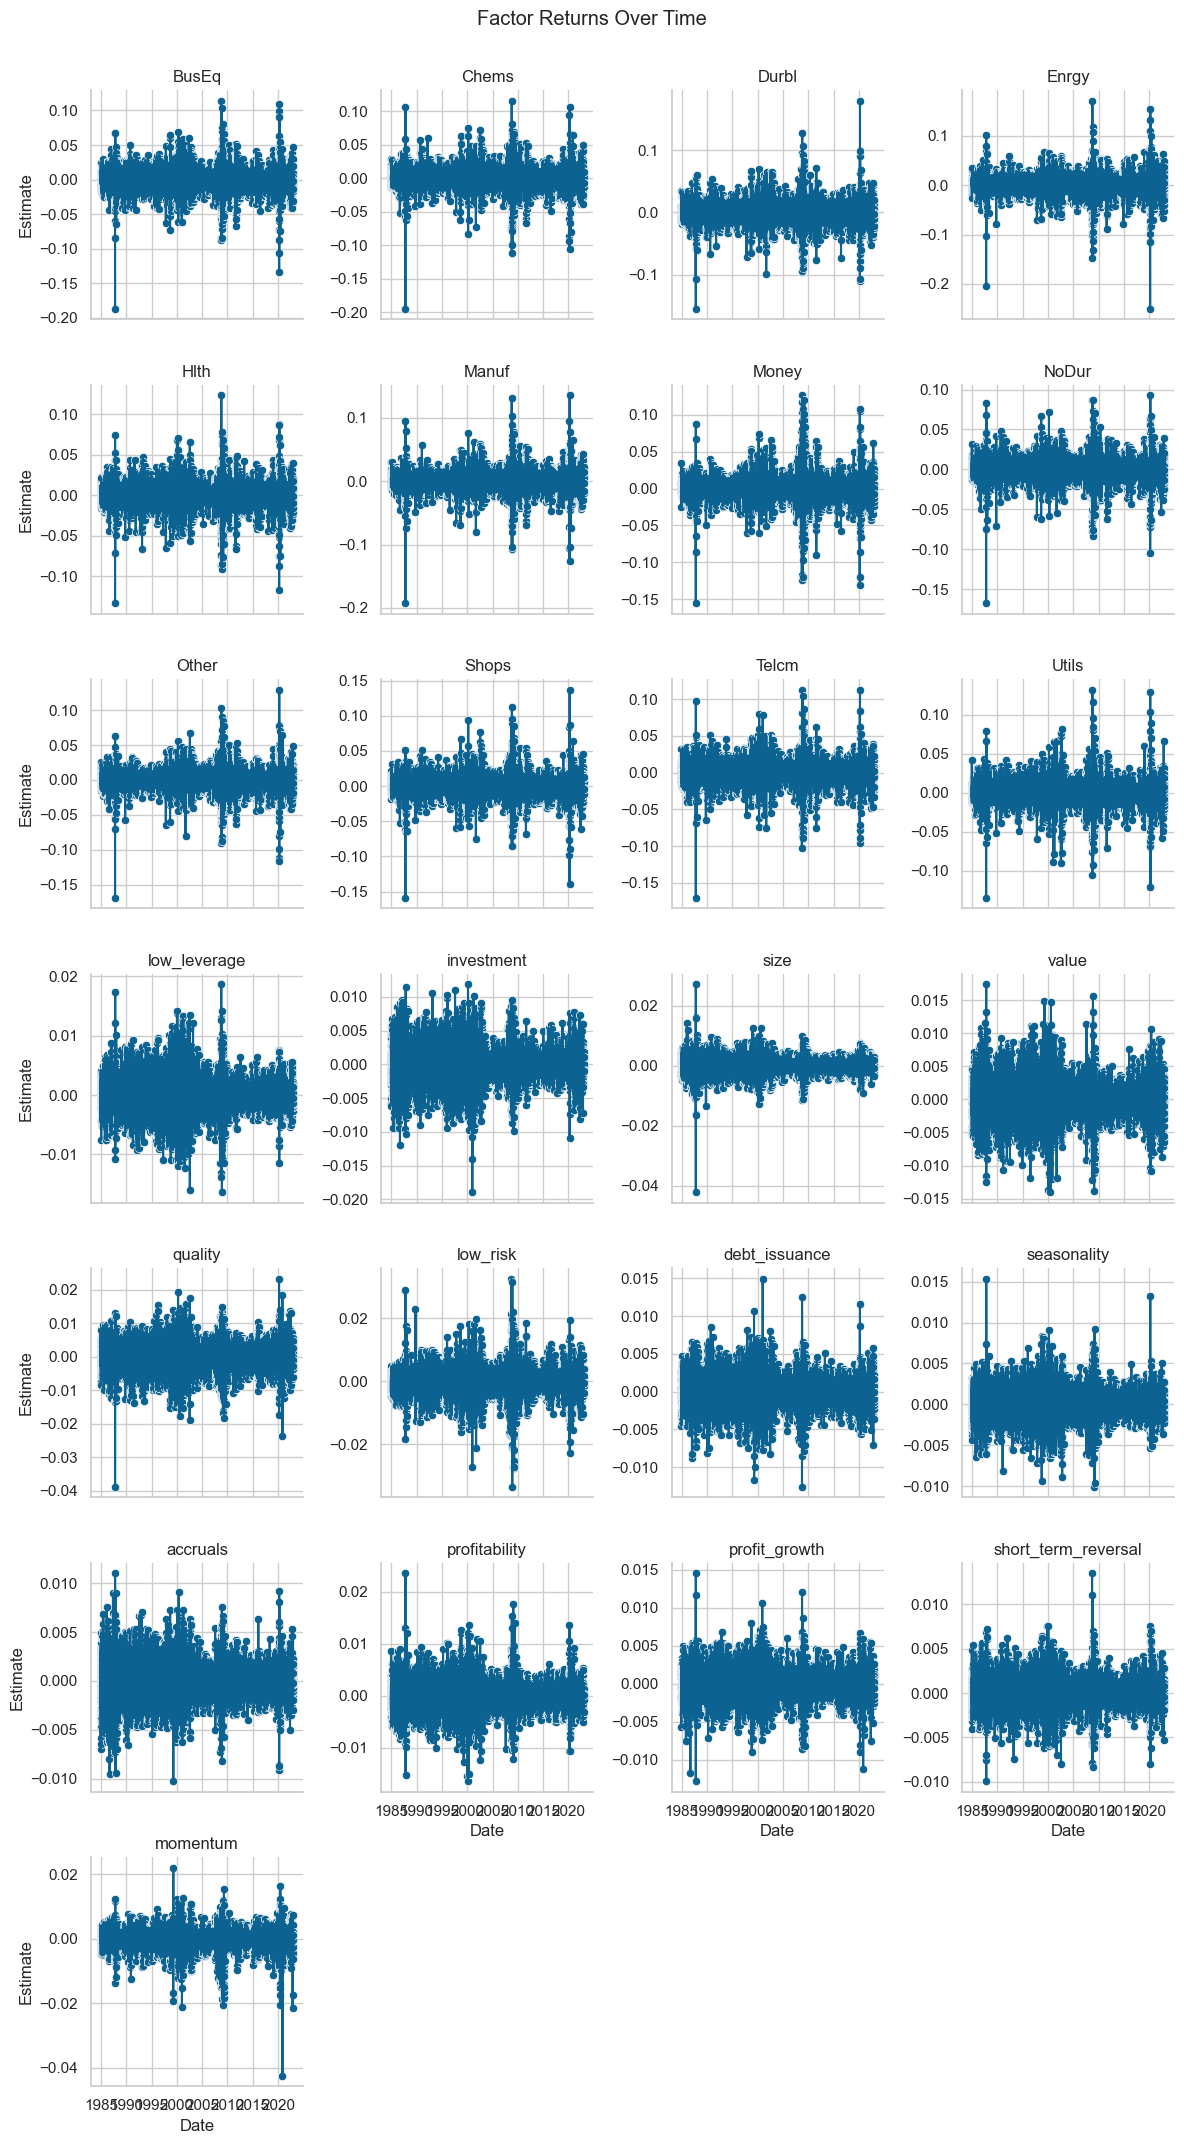

In [70]:
# Unnest tidy-data fra fct_ret_est
tidy_list = []
for idx, row in fct_ret_est.iterrows():
    tidy_df = row['tidied'].copy()
    tidy_df['date'] = row['date']
    tidy_list.append(tidy_df)
tidy_all = pd.concat(tidy_list, ignore_index=True)

# Hvis kolonnen med koefficienter hedder 'Coef.' eller 'Coef', omdøb til 'estimate'
if 'Coef.' in tidy_all.columns:
    tidy_all = tidy_all.rename(columns={'Coef.': 'estimate'})
elif 'Coef' in tidy_all.columns:
    tidy_all = tidy_all.rename(columns={'Coef': 'estimate'})

# 1. Plot: Faktorafkast over tid (facetteret efter term)
g = sns.FacetGrid(tidy_all, col="term", col_wrap=4, sharey=False, height=3)
g.map_dataframe(sns.lineplot, x="date", y="estimate")
g.map_dataframe(sns.scatterplot, x="date", y="estimate")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Date", "Estimate")
g.fig.suptitle("Factor Returns Over Time", y=1.02)
plt.show()

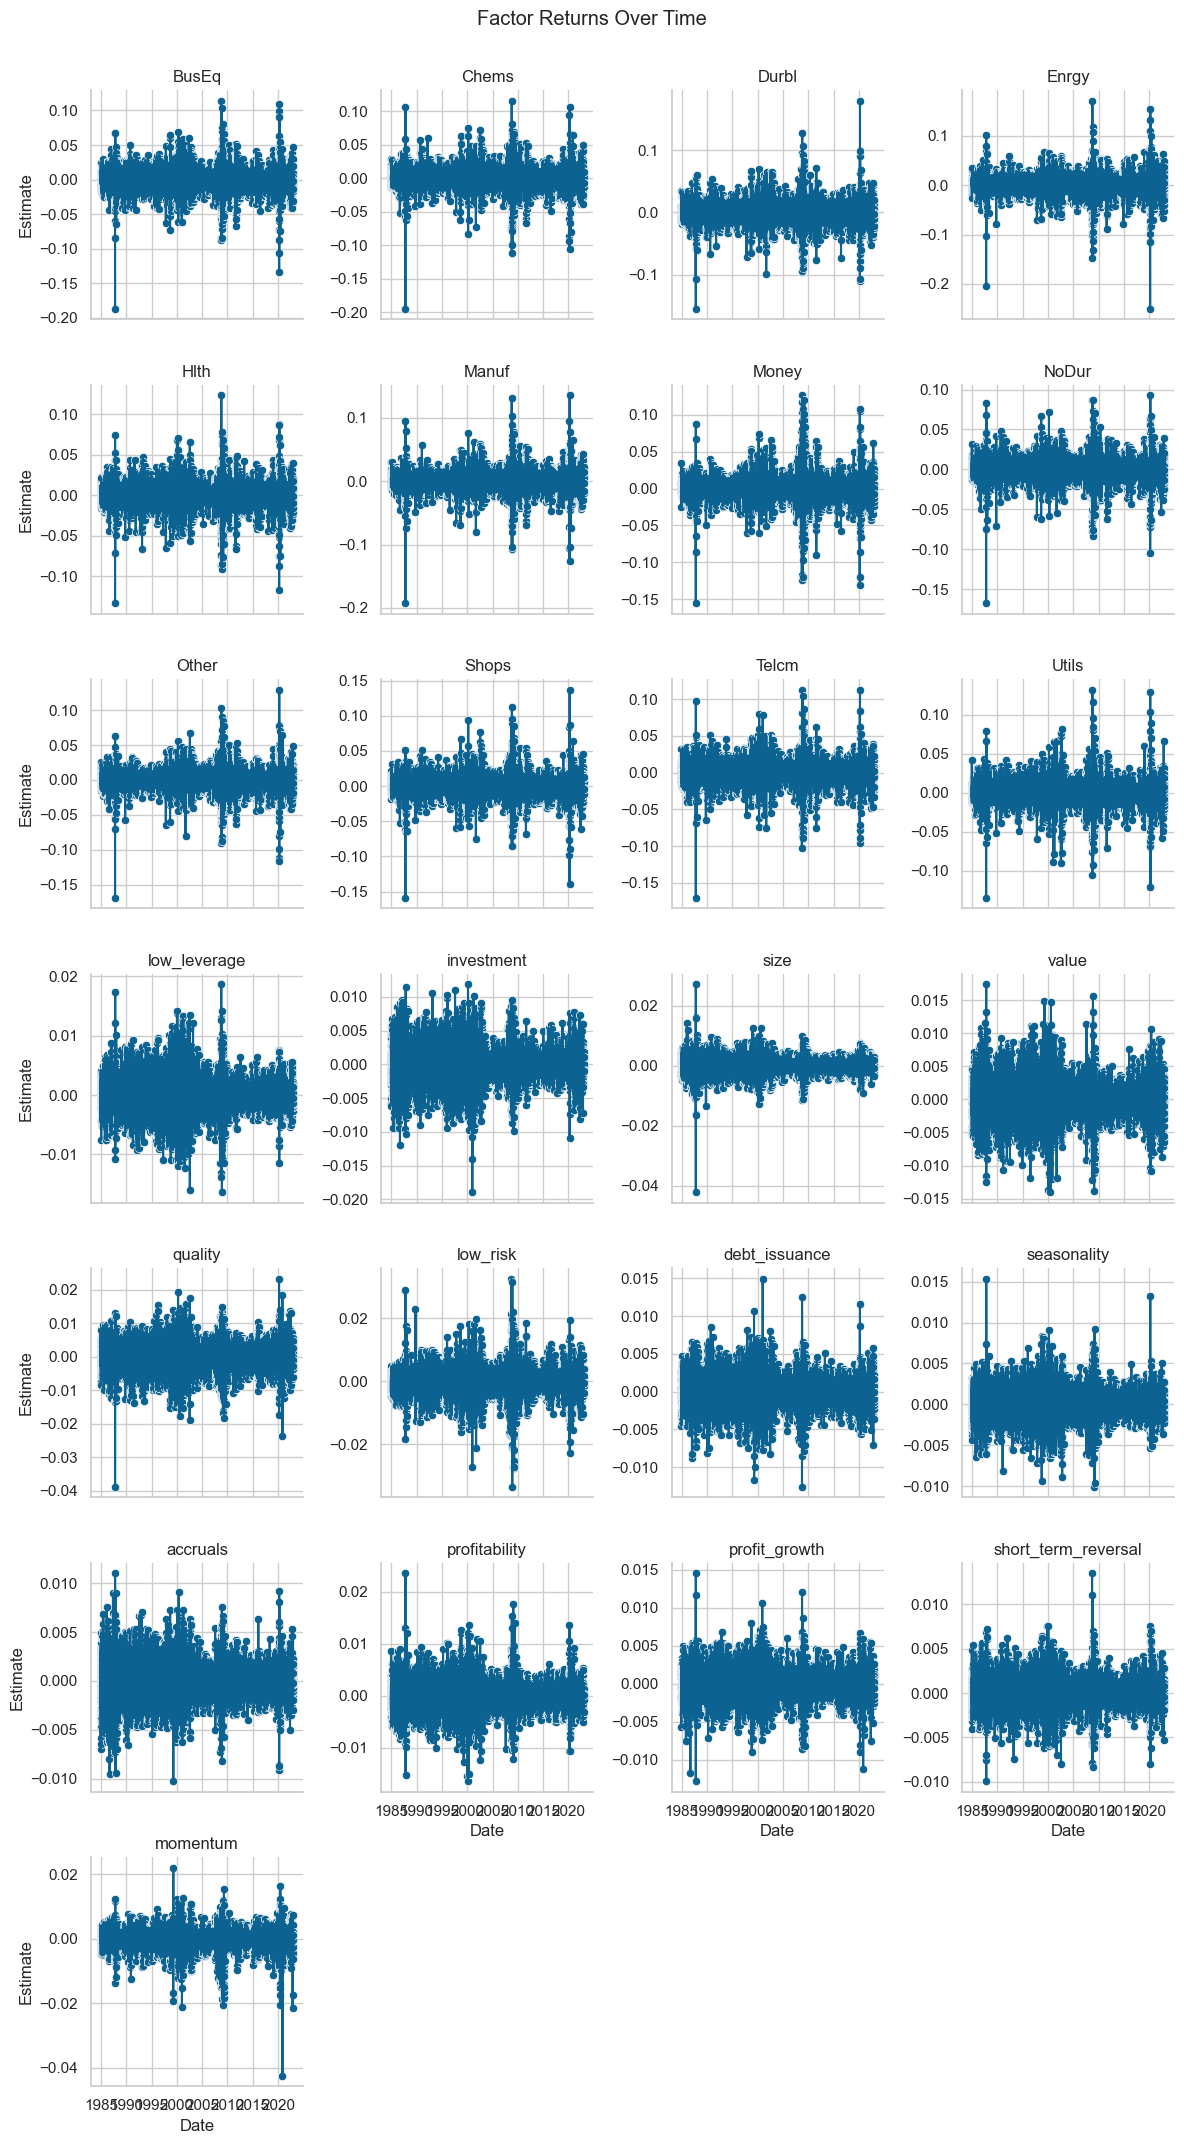

In [71]:
# Unnest tidy-data fra fct_ret_est
tidy_list = []
for idx, row in fct_ret_est.iterrows():
    tidy_df = row['tidied'].copy()
    tidy_df['date'] = row['date']
    tidy_list.append(tidy_df)
tidy_all = pd.concat(tidy_list, ignore_index=True)

# Hvis kolonnen med koefficienter hedder 'Coef.' eller 'Coef', omdøb til 'estimate'
if 'Coef.' in tidy_all.columns:
    tidy_all = tidy_all.rename(columns={'Coef.': 'estimate'})
elif 'Coef' in tidy_all.columns:
    tidy_all = tidy_all.rename(columns={'Coef': 'estimate'})

# 1. Plot: Faktorafkast over tid (facetteret efter term)
g = sns.FacetGrid(tidy_all, col="term", col_wrap=4, sharey=False, height=3)
g.map_dataframe(sns.lineplot, x="date", y="estimate")
g.map_dataframe(sns.scatterplot, x="date", y="estimate")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Date", "Estimate")
g.fig.suptitle("Factor Returns Over Time", y=1.02)
plt.show()

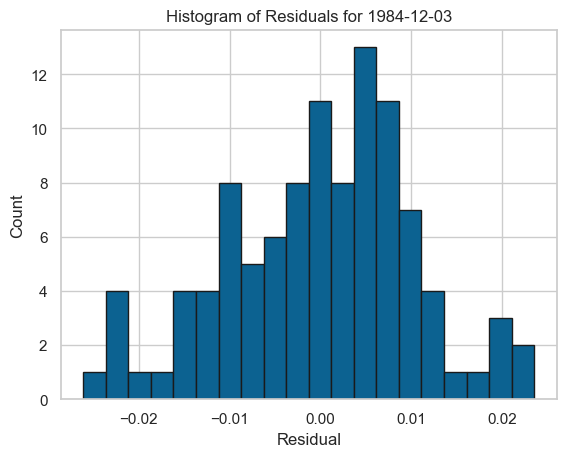

In [72]:
# 2. Residualanalyse for en specifik dato
# Vælg en specifik dato – her vælges den første række
row0 = fct_ret_est.iloc[0]
model = row0['fit']
residuals = model.resid
fitted = model.fittedvalues
date_val = row0['date']

# Histogram over residualer
plt.figure()
plt.hist(residuals, bins=20, edgecolor="k")
plt.title(f"Histogram of Residuals for {date_val.date()}")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

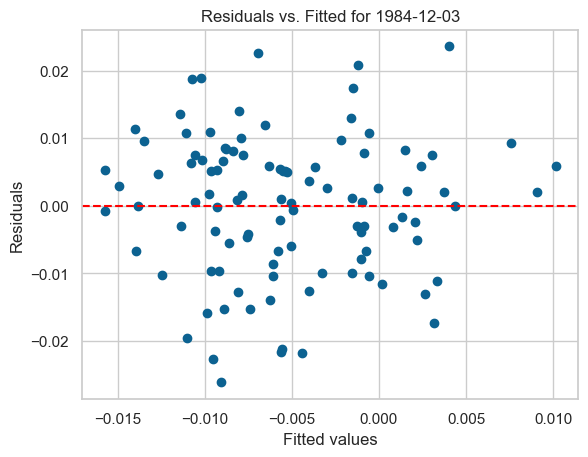

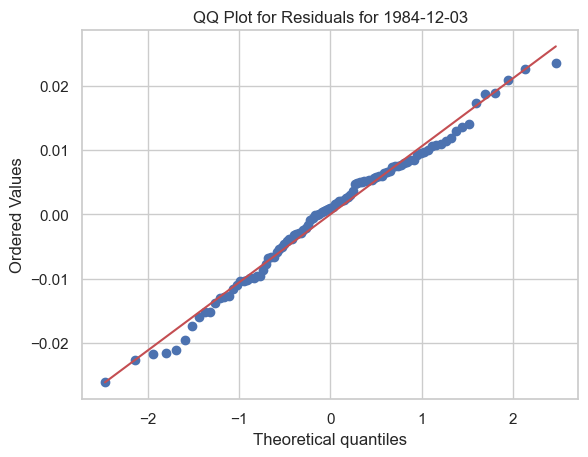

In [73]:
# Residual vs. Fitted plot
plt.figure()
plt.scatter(fitted, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title(f"Residuals vs. Fitted for {date_val.date()}")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# QQ-plot for residualerne
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title(f"QQ Plot for Residuals for {date_val.date()}")
plt.show()

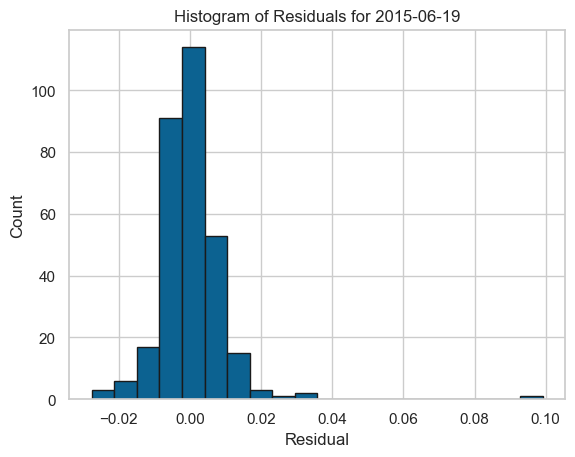

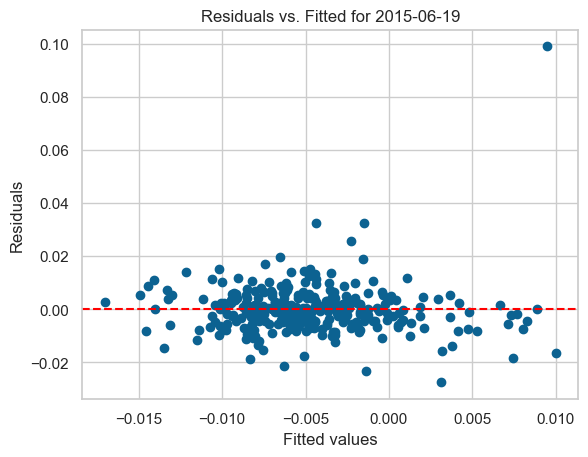

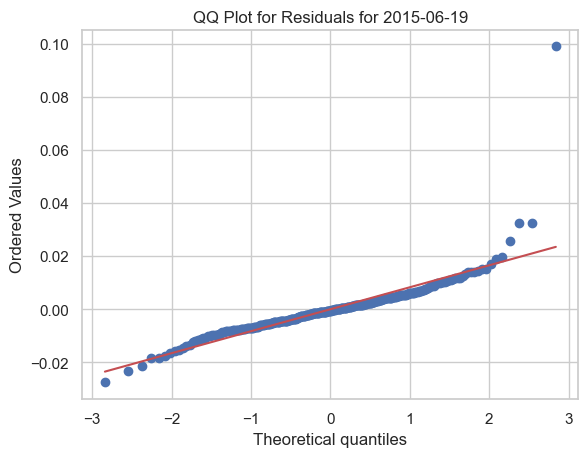

In [74]:
# 2. Residualanalyse for en specifik dato
# Vælg en specifik dato – her vælges den første række
row0 = fct_ret_est.iloc[7700]
model = row0['fit']
residuals = model.resid
fitted = model.fittedvalues
date_val = row0['date']

# Histogram over residualer
plt.figure()
plt.hist(residuals, bins=20, edgecolor="k")
plt.title(f"Histogram of Residuals for {date_val.date()}")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

# Residual vs. Fitted plot
plt.figure()
plt.scatter(fitted, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title(f"Residuals vs. Fitted for {date_val.date()}")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# QQ-plot for residualerne
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title(f"QQ Plot for Residuals for {date_val.date()}")
plt.show()

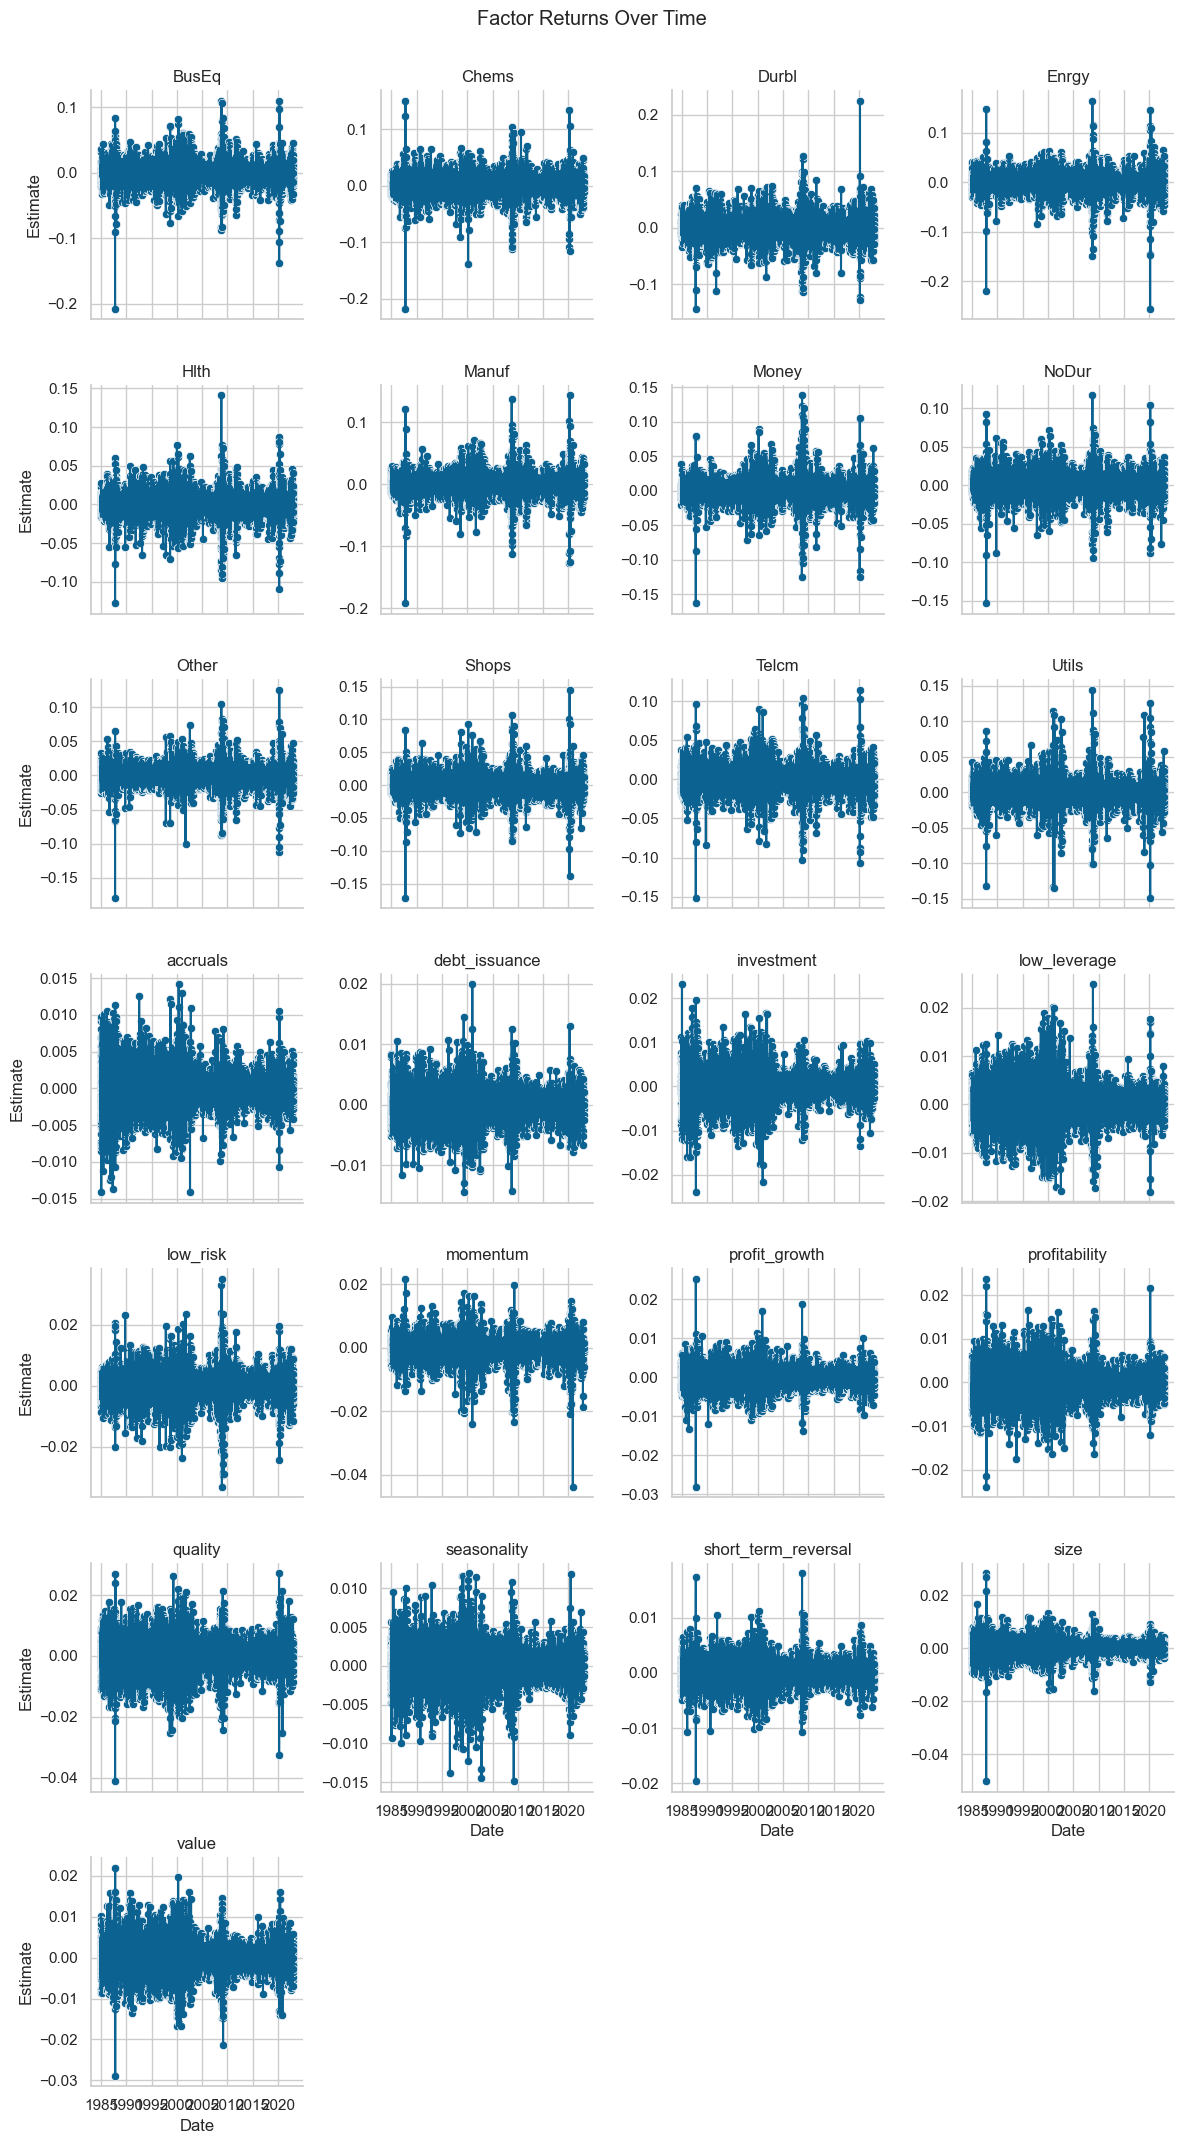

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Antag, at fct_ret er en DataFrame med 'date' og kolonner for de forskellige termer
# Smelt dataene til long format
fct_ret_long = fct_ret.melt(id_vars='date', var_name='term', value_name='estimate')

# Sørg for, at 'date' er datetime
fct_ret_long['date'] = pd.to_datetime(fct_ret_long['date'])

# Lav et facet-grid: Hver term i sin egen plot
g = sns.FacetGrid(fct_ret_long, col="term", col_wrap=4, sharey=False, height=3)
g.map_dataframe(sns.lineplot, x="date", y="estimate")
g.map_dataframe(sns.scatterplot, x="date", y="estimate")
g.set_axis_labels("Date", "Estimate")
g.set_titles("{col_name}")
g.fig.suptitle("Factor Returns Over Time", y=1.02)
plt.show()


In [40]:
print(fct_ret.shape)

(9598, 26)


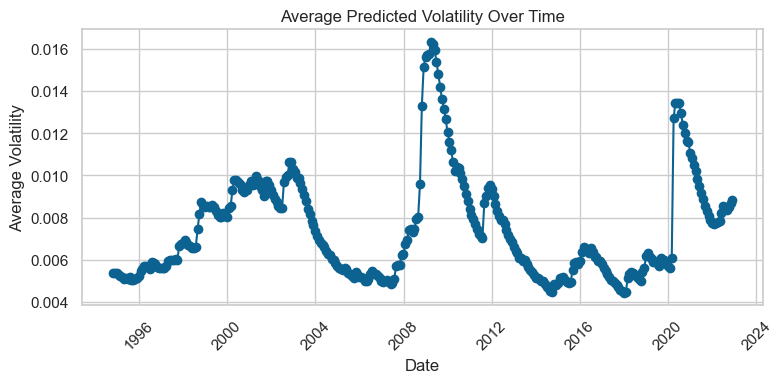

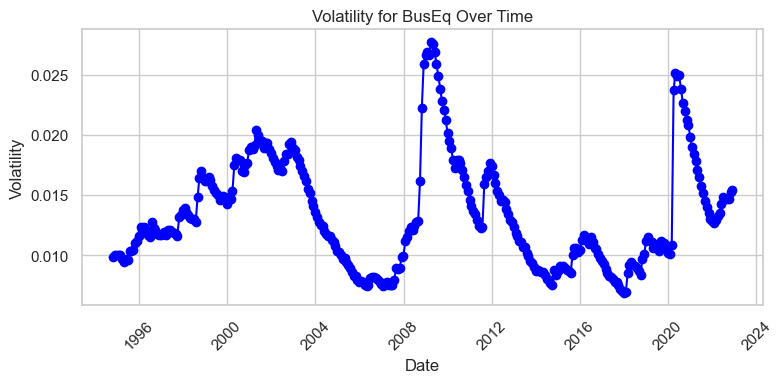

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Udtræk og beregn gennemsnitlig volatilitet for hver dato
vol_data = []
for d, mat in factor_cov_est.items():
    avg_vol = np.mean(np.sqrt(np.diag(mat.values)))
    vol_data.append({"date": pd.to_datetime(d), "avg_vol": avg_vol})
vol_data = pd.DataFrame(vol_data).sort_values("date")

# Plot: Gennemsnitlig forudsagt volatilitet over tid
plt.figure(figsize=(8, 4))
plt.plot(vol_data["date"], vol_data["avg_vol"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Average Volatility")
plt.title("Average Predicted Volatility Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Vælg en specifik faktor (fx den første kolonne i den første kovariansmatrix)
first_key = next(iter(factor_cov_est))
selected_factor = factor_cov_est[first_key].columns[0]

# Beregn volatilitet for den valgte faktor for hver dato
vol_data["selected_vol"] = [np.sqrt(mat.loc[selected_factor, selected_factor]) 
                            for mat in factor_cov_est.values()]

plt.figure(figsize=(8, 4))
plt.plot(vol_data["date"], vol_data["selected_vol"], marker="o", linestyle="-", color="blue")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title(f"Volatility for {selected_factor} Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


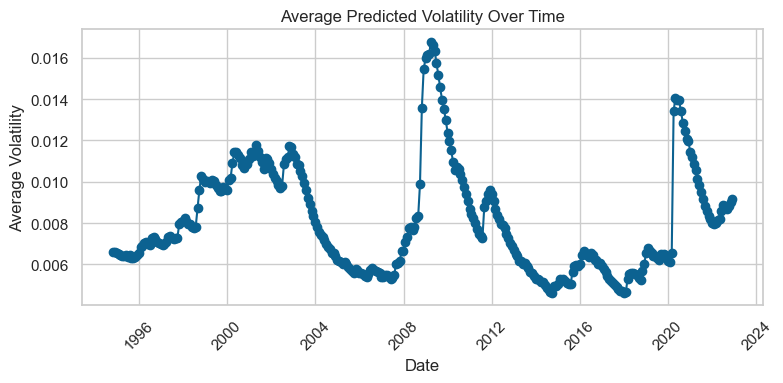

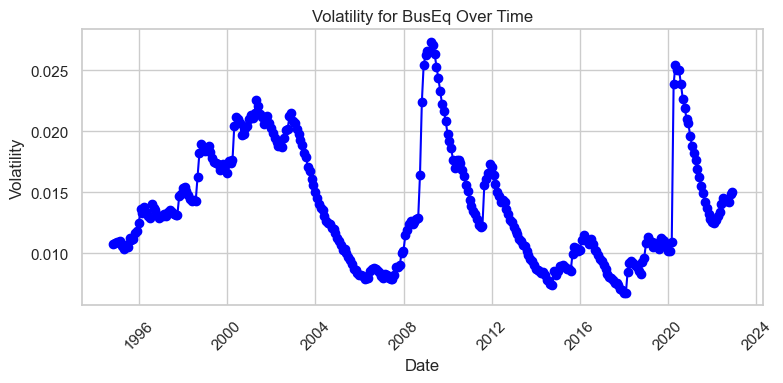

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Udtræk og beregn gennemsnitlig volatilitet for hver dato
vol_data = []
for d, mat in factor_cov_est.items():
    avg_vol = np.mean(np.sqrt(np.diag(mat.values)))
    vol_data.append({"date": pd.to_datetime(d), "avg_vol": avg_vol})
vol_data = pd.DataFrame(vol_data).sort_values("date")

# Plot: Gennemsnitlig forudsagt volatilitet over tid
plt.figure(figsize=(8, 4))
plt.plot(vol_data["date"], vol_data["avg_vol"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Average Volatility")
plt.title("Average Predicted Volatility Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Vælg en specifik faktor (fx den første kolonne i den første kovariansmatrix)
first_key = next(iter(factor_cov_est))
selected_factor = factor_cov_est[first_key].columns[0]

# Beregn volatilitet for den valgte faktor for hver dato
vol_data["selected_vol"] = [np.sqrt(mat.loc[selected_factor, selected_factor]) 
                            for mat in factor_cov_est.values()]

plt.figure(figsize=(8, 4))
plt.plot(vol_data["date"], vol_data["selected_vol"], marker="o", linestyle="-", color="blue")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title(f"Volatility for {selected_factor} Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Symmetri-tjek:
{numpy.datetime64('1994-10-31T00:00:00.000000000'): True, numpy.datetime64('1994-11-30T00:00:00.000000000'): True, numpy.datetime64('1994-12-31T00:00:00.000000000'): True, numpy.datetime64('1995-01-31T00:00:00.000000000'): True, numpy.datetime64('1995-02-28T00:00:00.000000000'): True, numpy.datetime64('1995-03-31T00:00:00.000000000'): True, numpy.datetime64('1995-04-30T00:00:00.000000000'): True, numpy.datetime64('1995-05-31T00:00:00.000000000'): True, numpy.datetime64('1995-06-30T00:00:00.000000000'): True, numpy.datetime64('1995-07-31T00:00:00.000000000'): True, numpy.datetime64('1995-08-31T00:00:00.000000000'): True, numpy.datetime64('1995-09-30T00:00:00.000000000'): True, numpy.datetime64('1995-10-31T00:00:00.000000000'): True, numpy.datetime64('1995-11-30T00:00:00.000000000'): True, numpy.datetime64('1995-12-31T00:00:00.000000000'): True, numpy.datetime64('1996-01-31T00:00:00.000000000'): True, numpy.datetime64('1996-02-29T00:00:00.000000000'): True, numpy.datetime6

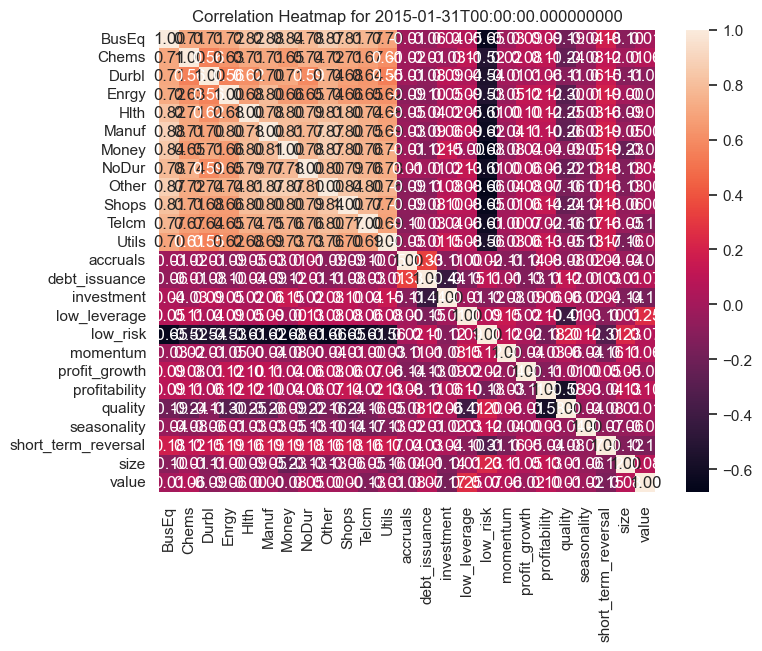

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Funktion til at tjekke symmetri
def is_symmetric(mat):
    return np.allclose(mat, mat.T)

sym_checks = {d: is_symmetric(mat.values) for d, mat in factor_cov_est.items()}
print("Symmetri-tjek:")
print(sym_checks)

# Funktion til at tjekke positive semidefiniteness
def is_psd(mat):
    eigvals = np.linalg.eigvalsh(mat.values)
    return np.all(eigvals >= -1e-8)  # tolerance
psd_checks = {d: is_psd(mat) for d, mat in factor_cov_est.items()}
print("PSD-tjek:")
print(psd_checks)

# Vælg en specifik dato for at visualisere korrelationsmatrixen
selected_date = list(factor_cov_est.keys())[243]
cov_mat = factor_cov_est[selected_date].values

# Konverter covariance matrix til correlation matrix
std = np.sqrt(np.diag(cov_mat))
corr_mat = cov_mat / np.outer(std, std)
np.fill_diagonal(corr_mat, 1.0)

plt.figure(figsize=(8,6))
sns.heatmap(corr_mat, annot=True, fmt=".2f",
            xticklabels=factor_cov_est[selected_date].columns,
            yticklabels=factor_cov_est[selected_date].columns)
plt.title(f"Correlation Heatmap for {selected_date}")
plt.show()


In [84]:
#factor_cov_est

In [78]:
date_key = np.datetime64('1994-10-31', 'ns')  # 'ns' for nanosekunder
print(factor_cov_est[date_key])

                            BusEq         Chems         Durbl         Enrgy  \
BusEq                1.155408e-04  7.666353e-05  4.037356e-05  4.662482e-05   
Chems                7.666353e-05  2.457596e-04  4.650663e-05  5.915319e-05   
Durbl                4.037356e-05  4.650663e-05  1.646124e-04  3.419943e-05   
Enrgy                4.662482e-05  5.915319e-05  3.419943e-05  1.229910e-04   
Hlth                 5.193525e-05  7.812292e-05  3.580614e-05  3.050393e-05   
Manuf                5.355705e-05  6.329318e-05  4.156797e-05  4.428341e-05   
Money                3.926325e-05  4.164956e-05  2.855312e-05  3.243135e-05   
NoDur                6.004820e-05  9.051638e-05  4.157589e-05  3.702542e-05   
Other                3.773106e-05  4.275379e-05  3.467044e-05  3.906812e-05   
Shops                5.304279e-05  7.193783e-05  4.839199e-05  3.209945e-05   
Telcm                4.918380e-05  7.392379e-05  4.286039e-05  6.189612e-05   
Utils                5.673167e-05  6.972897e-05  4.1

In [79]:
date_key = np.datetime64('2015-12-31', 'ns')  # 'ns' for nanosekunder
print(factor_cov_est[date_key])

                            BusEq         Chems         Durbl         Enrgy  \
BusEq                1.064432e-04  8.077508e-05  9.553213e-05  1.001916e-04   
Chems                8.077508e-05  1.183154e-04  8.260359e-05  9.477881e-05   
Durbl                9.553213e-05  8.260359e-05  1.662139e-04  1.010094e-04   
Enrgy                1.001916e-04  9.477881e-05  1.010094e-04  1.955812e-04   
Hlth                 9.282291e-05  8.382334e-05  9.004083e-05  1.012931e-04   
Manuf                9.426532e-05  8.159447e-05  9.429286e-05  1.122139e-04   
Money                9.307427e-05  7.819646e-05  9.918841e-05  9.807778e-05   
NoDur                8.196481e-05  8.193223e-05  8.074351e-05  9.092430e-05   
Other                9.434229e-05  8.411024e-05  1.019758e-04  1.063233e-04   
Shops                7.881619e-05  7.270265e-05  8.435004e-05  8.658858e-05   
Telcm                7.847080e-05  7.202611e-05  8.257702e-05  8.775432e-05   
Utils                7.182467e-05  6.649514e-05  7.3

In [80]:
import pandas as pd
import numpy as np

records = []
for date_key, df in factor_cov_est.items():
    # Konverter covariance matrix til correlation matrix
    cov_mat = df.values
    std = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / np.outer(std, std)
    # Sæt diagonalelementerne til NaN, så de ikke medtages i gennemsnittet
    np.fill_diagonal(corr_mat, np.nan)
    avg_corr = np.nanmean(corr_mat)
    # Konverter datoen til år
    year = pd.to_datetime(date_key).year
    records.append({"date": pd.to_datetime(date_key), "year": year, "avg_corr": avg_corr})

df_corr = pd.DataFrame(records)
avg_corr_by_year = df_corr.groupby("year")["avg_corr"].mean().reset_index()

print(avg_corr_by_year)


    year  avg_corr
0   1994  0.074310
1   1995  0.070031
2   1996  0.065933
3   1997  0.073109
4   1998  0.092206
5   1999  0.094443
6   2000  0.077162
7   2001  0.069383
8   2002  0.077934
9   2003  0.083694
10  2004  0.086930
11  2005  0.087069
12  2006  0.090333
13  2007  0.095793
14  2008  0.109009
15  2009  0.128895
16  2010  0.130605
17  2011  0.132344
18  2012  0.133486
19  2013  0.131989
20  2014  0.131755
21  2015  0.127802
22  2016  0.121600
23  2017  0.114279
24  2018  0.112134
25  2019  0.097657
26  2020  0.107570
27  2021  0.109530
28  2022  0.113057


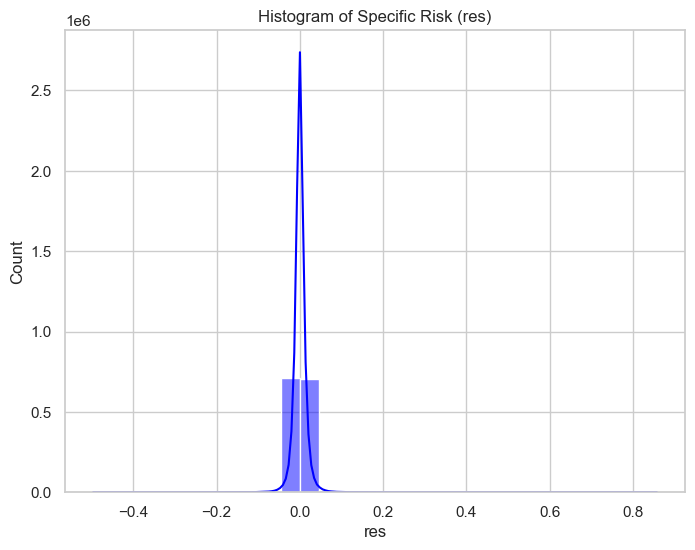

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.histplot(spec_risk['res'], bins=30, kde=True, color='blue')
plt.title("Histogram of Specific Risk (res)")
plt.xlabel("res")
plt.ylabel("Count")
plt.show()


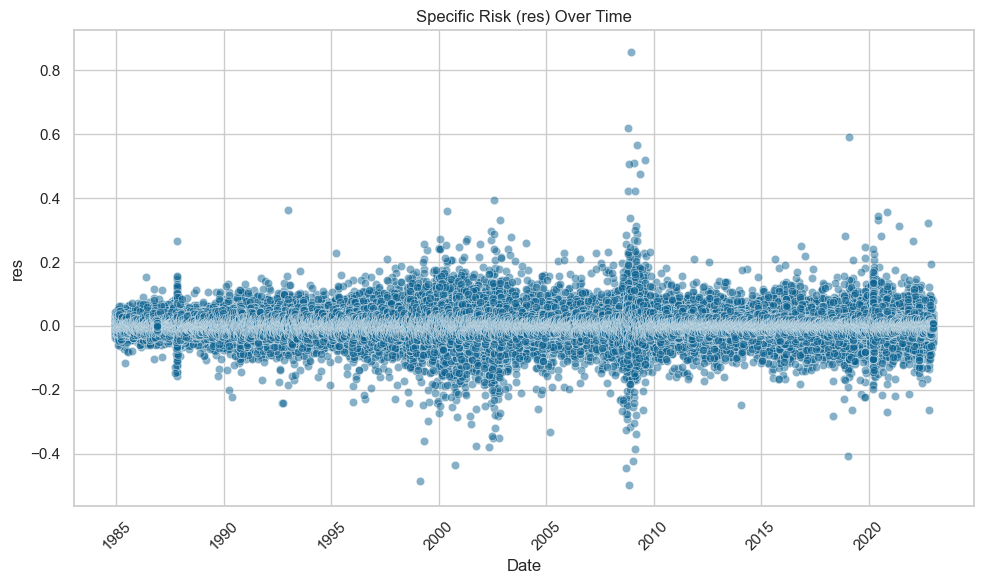

In [86]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=spec_risk, x='date', y='res', alpha=0.5)
plt.title("Specific Risk (res) Over Time")
plt.xlabel("Date")
plt.ylabel("res")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


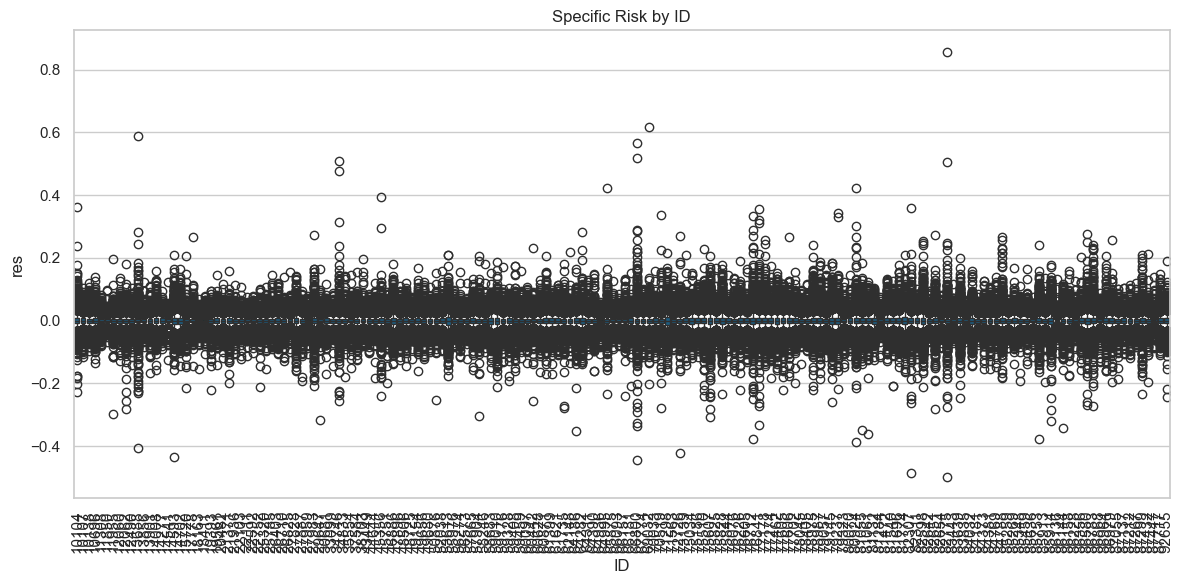

In [87]:
plt.figure(figsize=(12,6))
sns.boxplot(data=spec_risk, x='id', y='res')
plt.title("Specific Risk by ID")
plt.xlabel("ID")
plt.ylabel("res")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


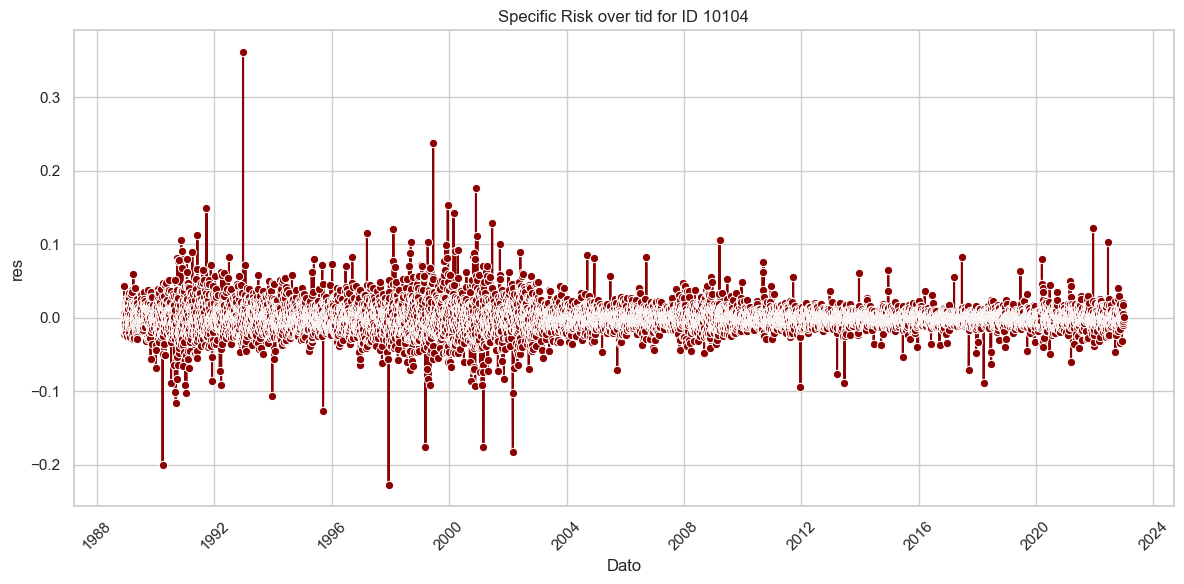

In [89]:
# Sørg for, at 'date' er datetime; f.eks. spec_risk['date'] = pd.to_datetime(spec_risk['date'])
spec_risk_10104 = spec_risk[spec_risk['id'] == 10104]

plt.figure(figsize=(12,6))
sns.lineplot(data=spec_risk_10104, x='date', y='res', marker='o', color='darkred')
plt.title("Specific Risk over tid for ID 10104")
plt.xlabel("Dato")
plt.ylabel("res")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


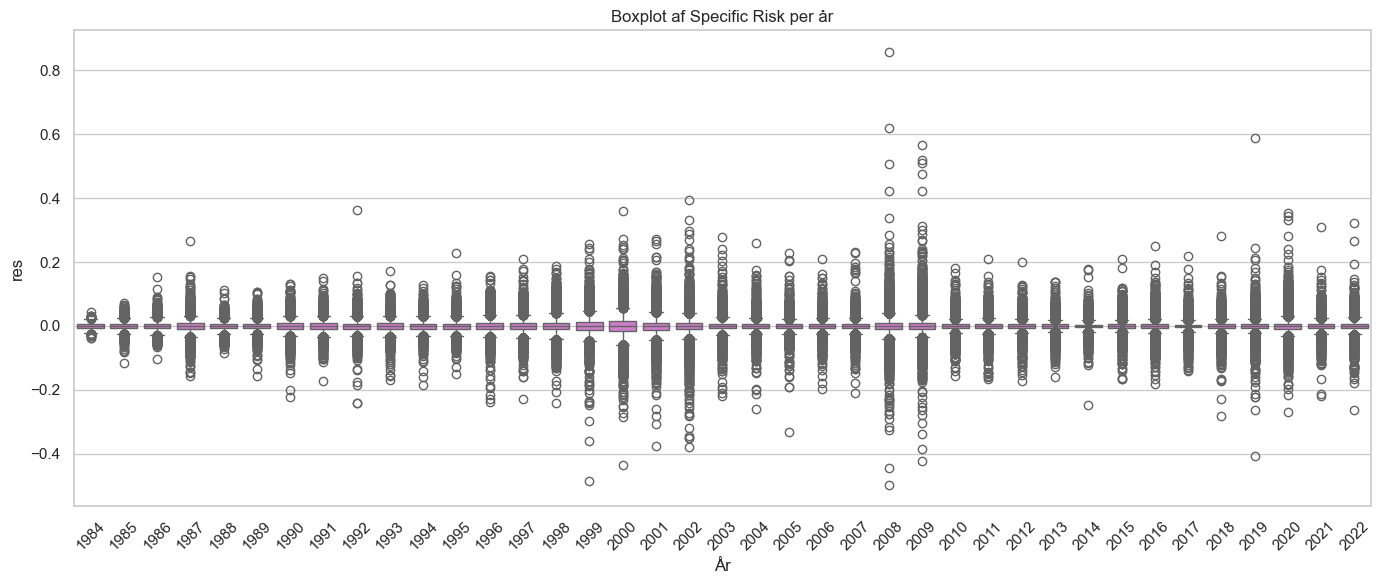

In [90]:
spec_risk['year'] = spec_risk['date'].dt.year

plt.figure(figsize=(14,6))
sns.boxplot(data=spec_risk, x='year', y='res', color='orchid')
plt.title("Boxplot af Specific Risk per år")
plt.xlabel("År")
plt.ylabel("res")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


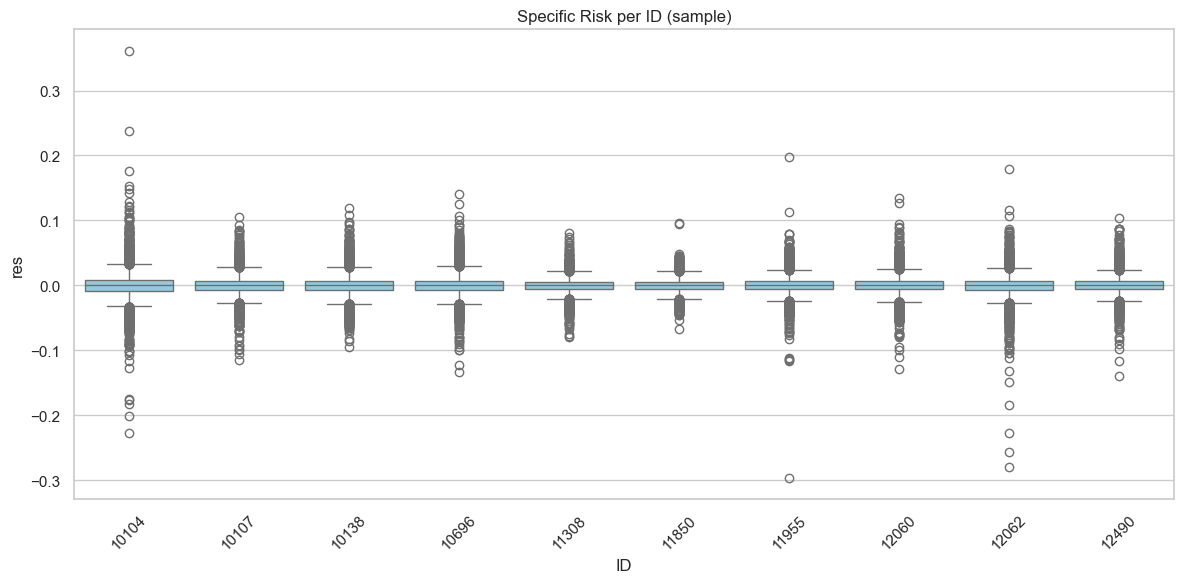

In [91]:
ids_sample = spec_risk['id'].unique()[:10]
spec_risk_sample = spec_risk[spec_risk['id'].isin(ids_sample)]

plt.figure(figsize=(12,6))
sns.boxplot(data=spec_risk_sample, x='id', y='res', color='skyblue')
plt.title("Specific Risk per ID (sample)")
plt.xlabel("ID")
plt.ylabel("res")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Dimensioner: (66710, 3)
Første 5 rækker:
        id        eom   res_vol
209  10104 1989-09-30  0.015939
231  10104 1989-10-31  0.016454
252  10104 1989-11-30  0.016532
272  10104 1989-12-31  0.015841
294  10104 1990-01-31  0.016954
Beskrivende statistik:
                 id                            eom       res_vol
count  66710.000000                          66710  6.671000e+04
mean   55161.335632  2006-11-06 21:40:20.326787840  1.398952e-02
min    10104.000000            1985-12-31 00:00:00  2.144357e-17
25%    27959.000000            1999-03-31 00:00:00  9.794293e-03
50%    60628.000000            2007-07-31 00:00:00  1.251073e-02
75%    78045.000000            2015-03-31 00:00:00  1.653867e-02
max    92655.000000            2022-12-31 00:00:00  9.358781e-02
std    25654.344153                            NaN  6.441381e-03


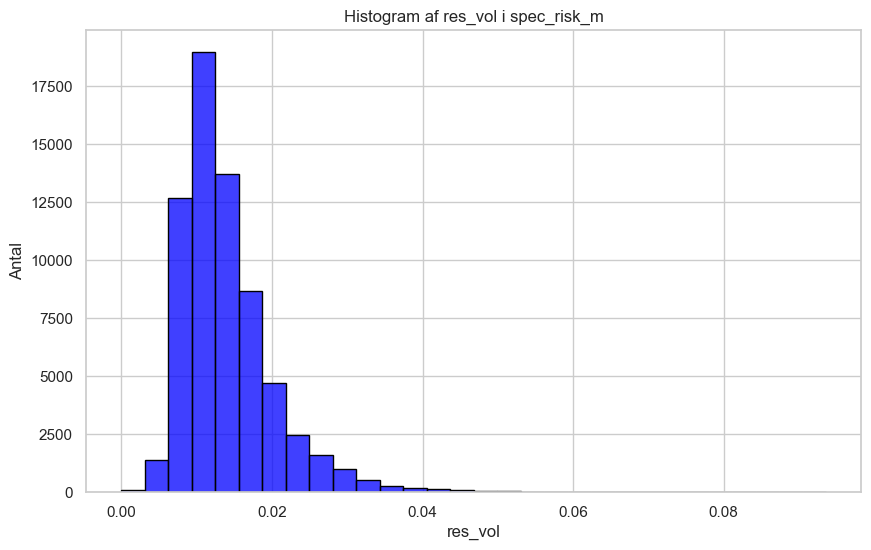

Unikke eom:
<DatetimeArray>
['1989-09-30 00:00:00', '1989-10-31 00:00:00', '1989-11-30 00:00:00',
 '1989-12-31 00:00:00', '1990-01-31 00:00:00', '1990-02-28 00:00:00',
 '1990-03-31 00:00:00', '1990-04-30 00:00:00', '1990-05-31 00:00:00',
 '1990-06-30 00:00:00']
Length: 10, dtype: datetime64[ns]


In [104]:
# Antag spec_risk_m er en Pandas DataFrame
print("Dimensioner:", spec_risk_m.shape)
print("Første 5 rækker:")
print(spec_risk_m.head())
print("Beskrivende statistik:")
print(spec_risk_m.describe())

# Histogram over res_vol
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(spec_risk_m['res_vol'], bins=30, color='blue', edgecolor='black')
plt.title("Histogram af res_vol i spec_risk_m")
plt.xlabel("res_vol")
plt.ylabel("Antal")
plt.show()

# Tjek unikke datoer (fx de første par datoer)
print("Unikke eom:")
print(spec_risk_m['eom'].unique()[:10])


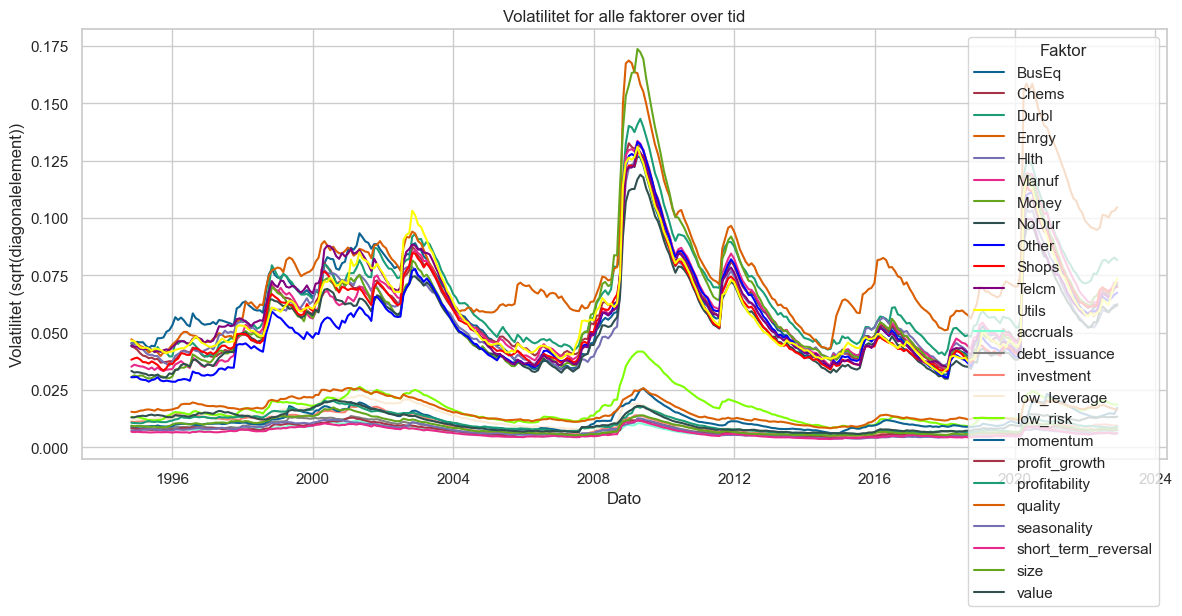

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Forudsætning: barra_cov er en dictionary, hvor nøglerne er datoer,
# og hver værdi er en dictionary med en key 'fct_cov', der er en pandas DataFrame.
# Eksempel: barra_cov['2012-12-31']['fct_cov']

# Sorter datoerne
dates = sorted(barra_cov.keys())

# Hent faktornavne fra fct_cov for den første dato
first_date = dates[0]
factor_names = barra_cov[first_date]['fct_cov'].columns.tolist()

# Saml data: for hver dato og for hver faktor udregnes volatiliteten (sqrt af diagonalelementet)
records = []
for date in dates:
    df = barra_cov[date]['fct_cov']
    for factor in factor_names:
        vol = np.sqrt(df.loc[factor, factor])
        records.append({'date': pd.to_datetime(date), 'factor': factor, 'vol': vol})

# Konverter listen til en DataFrame
vol_data = pd.DataFrame(records)

# Plot: lav en linje for hver faktor over tid
plt.figure(figsize=(12, 6))
for factor in factor_names:
    subset = vol_data[vol_data['factor'] == factor]
    plt.plot(subset['date'], subset['vol'], label=factor)

plt.title("Volatilitet for alle faktorer over tid")
plt.xlabel("Dato")
plt.ylabel("Volatilitet (sqrt(diagonalelement))")
plt.legend(title="Faktor")
plt.tight_layout()
plt.show()
